# Librerias

In [2]:
!pip install factor-analyzer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 3.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for factor-analyzer: filename=factor_analyzer-0.5.1-py2.py3-none-any.whl size=42655 sha256=7eb480a1e988260d2deb67ef2c053b5069778db41146c56e629a538df2ca61fa
  Stored in directory: /root/.cache/pip/wheels/a2/af/06/f4d4ed4d9d714fda437fb1583629417319603c2266e7b233cc
Successfully built factor-analyzer


In [13]:
#!pip install cupy-cuda11x # Instala CuPy con soporte CUDA 11.x

import pandas as pd
import os
import cv2
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import gc
import umap
from google.colab import drive
from factor_analyzer import FactorAnalyzer
from tqdm.notebook import tqdm
import seaborn as sns
from imblearn.over_sampling import SMOTE # Corrected from SMOT
from imblearn.combine import SMOTEENN


from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import trustworthiness, _utils
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import layers, models, callbacks, utils, initializers
from tensorflow.keras import regularizers

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


# Preprocesamiento de las imágenes

## Carga de las imágenes

In [ ]:
folder_path = '/content/drive/MyDrive/enfermedades oculares/preprocessed_images'
IMG_SIZE = (100, 100)

def load_all_images(folder, img_size):

    images_list = [] # Lista para almacenar las matrices de imágenes
    filenames_list = []

    # Verifica si la carpeta existe.
    if not os.path.exists(folder):
        print(f"Error: La carpeta '{folder}' no fue encontrada.")
        return np.array([]),[]

    for filename in os.listdir(folder):
        if filename.endswith(('jpg', 'png', 'jpeg')):
            file_path = os.path.join(folder, filename)

            # Carga la imagen a color
            img = cv2.imread(file_path)

            if img is not None:
                img_resized = cv2.resize(img, img_size)
                images_list.append(img_resized)
                filenames_list.append(filename)
            else:
                print(f"Advertencia: No se pudo cargar la imagen {filename}. Se omitirá.")

    return images_list, filenames_list

#Llama a la función para cargar todas las imágenes en una lista
all_images,image_filenames = load_all_images(folder_path, IMG_SIZE)



In [ ]:
print("Número de imágenes cargadas:", len(all_images))
print("Número de nombres registrados:", len(image_filenames))
print("Primeros 10 nombres de imágenes:")
print(image_filenames[:10])

Número de imágenes cargadas: 6392
Número de nombres registrados: 6392
Primeros 10 nombres de imágenes:
['4784_left.jpg', '473_right.jpg', '487_left.jpg', '481_left.jpg', '476_right.jpg', '477_left.jpg', '489_left.jpg', '480_left.jpg', '481_right.jpg', '46_right.jpg']


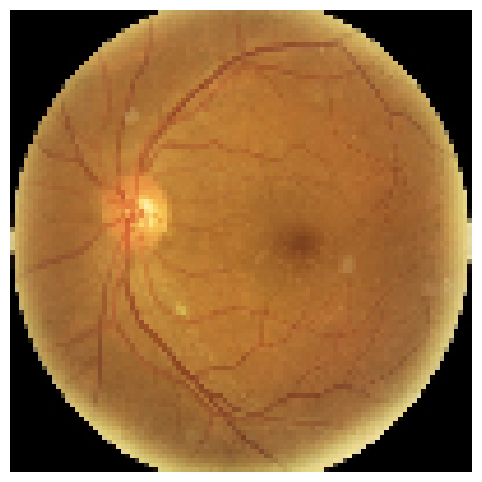


--- Contenido de la matriz (segmento central) ---
Forma del segmento: (5, 5, 3)
[[[ 47 116 179]
  [ 48 116 182]
  [ 48 117 179]
  [ 46 116 176]
  [ 48 112 176]]

 [[ 41 107 172]
  [ 48 116 182]
  [ 49 117 182]
  [ 44 112 176]
  [ 45 112 175]]

 [[ 45 116 180]
  [ 50 118 183]
  [ 48 116 181]
  [ 43 111 176]
  [ 45 109 174]]

 [[ 52 120 185]
  [ 47 118 181]
  [ 49 120 184]
  [ 45 113 178]
  [ 43 107 172]]

 [[ 48 114 179]
  [ 44 114 178]
  [ 50 121 186]
  [ 46 115 177]
  [ 43 109 172]]]


In [ ]:
# Visualiza la matriz de la primera imagen
if len(all_images) > 0:
    # Selecciona la primera imagen de la lista
    first_image = all_images[0]

    # Convierte el formato de color de BGR (OpenCV) a RGB (Matplotlib)
    first_image_rgb = cv2.cvtColor(first_image, cv2.COLOR_BGR2RGB)


    # Define el tamaño del segmento que quieres visualizar (por ejemplo, 5x5 píxeles)
    target_size = 5

    # Obtiene las dimensiones de la imagen
    h, w, c = first_image.shape

    # Calcula la esquina superior izquierda del segmento central
    start_y = (h - target_size) // 2
    start_x = (w - target_size) // 2


    # Extrae el segmento central de la matriz
    center_segment = first_image[start_y : start_y + target_size,
                             start_x : start_x + target_size]


    # Muestra la imagen usando Matplotlib
    plt.figure(figsize=(8, 6))
    plt.imshow(first_image_rgb)
    #plt.title(f"Visualización de la Matriz de una Imagen ({first_image.shape[0]}x{first_image.shape[1]}x{first_image.shape[2]})")
    plt.axis('off')
    plt.show()

    print("\n--- Contenido de la matriz (segmento central) ---")
    print(f"Forma del segmento: {center_segment.shape}")
    print(center_segment)
else:
    print("No se encontraron imágenes. Por favor, revisa la ruta y los archivos.")

## Aplanamiento de las matrices:

se convierte una matriz en un unico vector.

**Ejemplo:**

Matriz:

```
[[[5,   10,   50], [  20, 25,   15]],
 [[50,   20, 30], [23, 20,   15]]]
```

Vector plano:

```
[[5, 10, 50,    20, 25, 15,    50, 20, 30,    23, 20, 15]]
```


In [ ]:
if len(all_images) > 0:
    # toma la  lista y la convierte en un solo array de NumPy.
    # El resultado es una matriz con una forma de (6392,100,100,3),
    # donde la primera dimensión (6392) es el número de imágenes.
    images_array = np.array(all_images)

    # Obtiene las dimensiones del array (número de muestras, alto, ancho, canales)
    n_samples, h, w, c = images_array.shape

    # Aplana cada imagen a un vector unidimensional
    datos_aplanados = images_array.reshape((n_samples, h * w * c))

    print("Aplanamiento completado con éxito.")
    print(f"Forma de los datos aplanados: {datos_aplanados.shape}")
else:
    print("No se encontraron imágenes para aplanar.")

Aplanamiento completado con éxito.
Forma de los datos aplanados: (6392, 30000)


## Creación de labels

In [ ]:
# --- 1. CONFIGURACIÓN INICIAL ---
try:
    df = pd.read_csv('/content/drive/MyDrive/enfermedades oculares/full_df.csv')
    print("✅ DataFrame 'full_df.csv' cargado con éxito.")
except FileNotFoundError:
    print("🚨 Error: Asegúrate de que 'full_df.csv' esté en el directorio correcto.")
    exit()

✅ DataFrame 'full_df.csv' cargado con éxito.


In [ ]:
df.head(1)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg


In [ ]:
# Quita corchetes, comillas y espacios innecesarios
df["labels"] = df["labels"].str.replace(r"[\[\]' ]", "", regex=True)
df.head(1)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg


In [ ]:
# 1. Crear un diccionario: nombre_archivo → label
dicc_labels = dict(zip(df['filename'], df['labels']))

# 2. Crear lista final de labels para tus imágenes cargadas
labels_final = [dicc_labels[n] for n in image_filenames]


In [ ]:
print(labels_final[:10])

['H', 'O', 'O', 'M', 'O', 'C', 'D', 'O', 'N', 'M']


In [ ]:
encoder = LabelEncoder()
y = encoder.fit_transform(labels_final)

In [ ]:
print(y[:10])

[4 7 7 5 7 1 2 7 6 5]


In [ ]:
print(len(y))

6392


In [ ]:
for clase, codigo in zip(encoder.classes_, range(len(encoder.classes_))):
    print(f"{clase}  →  {codigo}")

A  →  0
C  →  1
D  →  2
G  →  3
H  →  4
M  →  5
N  →  6
O  →  7


## Dividir en datos de entrenamiento y testeo


In [ ]:
datos_aplanados_train, datos_aplanados_test, y_train, y_test, filenames_train, filenames_test = train_test_split(
    datos_aplanados,
    y,
    image_filenames,
    test_size=0.2,
    random_state=42,
    stratify=y
)


## Estandarización de los datos

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(datos_aplanados_train)
X_test_scaled  = scaler.transform(datos_aplanados_test)

In [ ]:
X_train_scaled.shape

(5113, 30000)

# Elección de factores y componentes

## Análisis paralelo

### PCA

In [ ]:
# --- GPU con CuPy ---
try:
    import cupy as cp
    xp = cp  # GPU
    print("✅ Usando GPU con CuPy")
except ImportError:
    xp = np
    print("⚠️ No se encontró CuPy, usando CPU")

# --- Función: Análisis paralelo (Horn) para PCA ---
def horn_pca(datos, n_vars=2000, num_simulations=50, num_repeats=3, random_state=42):
    """
    Análisis paralelo (Horn) para PCA en subconjuntos de variables.

    Parámetros:
        datos: ndarray (n_samples, n_features)
        n_vars: número de variables aleatorias a tomar en cada repetición
        num_simulations: número de simulaciones aleatorias por repetición
        num_repeats: número de repeticiones con diferentes subconjuntos
        random_state: semilla reproducible
    """
    rng = np.random.default_rng(random_state)
    n_samples, n_features = datos.shape
    resultados = []

    for rep in range(num_repeats):
        print(f"\n🔄 Repetición {rep+1}/{num_repeats}")

        # --- 1) Selección aleatoria de variables ---
        selected_vars = rng.choice(n_features, size=min(n_vars, n_features), replace=False)
        subset = datos[:, selected_vars]

        # --- 2) Estandarizar datos y calcular autovalores reales (PCA) ---
        subset = StandardScaler().fit_transform(subset)
        subset_gpu = xp.asarray(subset)

        cov_matrix = xp.cov(subset_gpu, rowvar=False)
        eigvals_real = xp.linalg.eigvalsh(cov_matrix)[::-1]  # orden descendente
        eigvals_real = xp.asnumpy(eigvals_real)

        # --- 3) Autovalores aleatorios ---
        rand_eigs = np.zeros((num_simulations, len(selected_vars)))
        for i in range(num_simulations):
            rnd = np.random.default_rng(random_state + i)
            random_data = rnd.normal(size=(n_samples, len(selected_vars))).astype(np.float32)
            random_data = StandardScaler().fit_transform(random_data)

            cov_rnd = np.cov(random_data, rowvar=False)
            eigs_rnd = np.linalg.eigvalsh(cov_rnd)[::-1]
            rand_eigs[i, :] = eigs_rnd

            del random_data, cov_rnd
            gc.collect()

        mean_rand_eigs = rand_eigs.mean(axis=0)

        # --- 4) Selección según Horn ---
        selected_mask = eigvals_real > mean_rand_eigs
        num_selected = selected_mask.sum()
        selected_indices = [i+1 for i, v in enumerate(selected_mask) if v]

        # --- 5) Varianza explicada ---
        total_var = eigvals_real.sum()
        var_individual = eigvals_real / total_var * 100
        var_acumulada = np.cumsum(var_individual)

        # --- 6) Tabla ---
        tabla = pd.DataFrame({
            "Componente": np.arange(1, len(selected_vars)+1),
            "Autovalor real": eigvals_real,
            "Autovalor aleatorio medio": mean_rand_eigs,
            "Varianza individual (%)": var_individual,
            "Varianza acumulada (%)": var_acumulada,
            "Seleccionado": selected_mask
        }).round(2)

        tabla_filtrada = tabla[tabla["Seleccionado"]].reset_index(drop=True)

        resultados.append({
            "repeticion": rep+1,
            "num_componentes": num_selected,
            "componentes": selected_indices,
            "tabla": tabla_filtrada
        })

        print(f"📌 Número de componentes retenidos (Horn PCA, repetición {rep+1}): {num_selected}")
        print(f"📊 Varianza acumulada al último componente retenido: {tabla_filtrada['Varianza acumulada (%)'].iloc[-1]:.2f}%")

    return resultados

    # --- Ejecutar análisis paralelo PCA ---
resultados_pca = horn_pca(
    datos=X_train_scaled,
    n_vars=2000,          # número de variables aleatorias por repetición
    num_simulations=50,   # número de simulaciones aleatorias
    num_repeats=3,        # número de repeticiones (distintos subconjuntos de variables)
    random_state=42
)

resultados_pca[-1]["tabla"]



✅ Usando GPU con CuPy

🔄 Repetición 1/3
📌 Número de componentes retenidos (Horn PCA, repetición 1): 32
📊 Varianza acumulada al último componente retenido: 94.21%

🔄 Repetición 2/3
📌 Número de componentes retenidos (Horn PCA, repetición 2): 31
📊 Varianza acumulada al último componente retenido: 94.13%

🔄 Repetición 3/3
📌 Número de componentes retenidos (Horn PCA, repetición 3): 30
📊 Varianza acumulada al último componente retenido: 94.08%


,Componente,Autovalor real,Autovalor aleatorio medio,Varianza individual (%),Varianza acumulada (%),Seleccionado
0,1,836.39,2.63,41.81,41.81,True
1,2,261.75,2.62,13.08,54.90,True
2,3,169.19,2.60,8.46,63.35,True
3,4,145.61,2.60,7.28,70.63,True
4,5,107.88,2.59,5.39,76.03,True
5,6,91.67,2.58,4.58,80.61,True
6,7,64.06,2.57,3.20,83.81,True
7,8,26.32,2.56,1.32,85.13,True
8,9,25.27,2.55,1.26,86.39,True
9,10,21.60,2.55,1.08,87.47,True


### AF

In [ ]:
# --- GPU con CuPy ---
try:
    import cupy as cp
    xp = cp  # GPU
    print("✅ Usando GPU con CuPy")
except ImportError:
    xp = np
    print("⚠️ No se encontró CuPy, usando CPU")

# --- Función: Análisis paralelo (Horn) para AF ---
def horn_af(datos, n_vars=2000, num_simulations=50, num_repeats=3, random_state=42):
    """
    Análisis paralelo (Horn) para AF en subconjuntos de variables.

    Parámetros:
        datos: ndarray (n_samples, n_features)
        n_vars: número de variables aleatorias a tomar en cada repetición
        num_simulations: número de simulaciones aleatorias por repetición
        num_repeats: número de repeticiones con diferentes subconjuntos
        random_state: semilla reproducible
    """
    rng = np.random.default_rng(random_state)
    n_samples, n_features = datos.shape
    resultados = []

    for rep in range(num_repeats):
        print(f"\n🔄 Repetición {rep+1}/{num_repeats}")

        # --- 1) Selección aleatoria de variables ---
        selected_vars = rng.choice(n_features, size=min(n_vars, n_features), replace=False)
        subset = datos[:, selected_vars]

        # --- 2) Matriz de correlación real ---
        subset_gpu = xp.asarray(subset)
        corr_matrix = xp.corrcoef(subset_gpu, rowvar=False)
        eigvals_real = xp.linalg.eigvalsh(corr_matrix)[::-1]  # orden descendente
        eigvals_real = xp.asnumpy(eigvals_real)  # devolver a CPU

        # --- 3) Autovalores aleatorios ---
        rand_eigs = np.zeros((num_simulations, len(selected_vars)))
        for i in range(num_simulations):
            rnd = np.random.default_rng(random_state + i)
            random_data = rnd.normal(size=(n_samples, len(selected_vars))).astype(np.float32)
            random_data = StandardScaler().fit_transform(random_data)

            corr_rnd = np.corrcoef(random_data.T)
            eigs_rnd = np.linalg.eigvalsh(corr_rnd)[::-1]
            rand_eigs[i, :] = eigs_rnd

            del random_data, corr_rnd
            gc.collect()

        mean_rand_eigs = rand_eigs.mean(axis=0)

        # --- 4) Selección según Horn ---
        selected_mask = eigvals_real > mean_rand_eigs
        num_selected = selected_mask.sum()
        selected_indices = [i+1 for i, v in enumerate(selected_mask) if v]

        # --- 5) Varianza explicada ---
        var_individual = eigvals_real / len(selected_vars) * 100
        var_acumulada = np.cumsum(var_individual)

        # --- 6) Tabla ---
        tabla = pd.DataFrame({
            "Factor": np.arange(1, len(selected_vars)+1),
            "Autovalor real": eigvals_real,
            "Autovalor aleatorio medio": mean_rand_eigs,
            "Varianza individual (%)": var_individual,
            "Varianza acumulada (%)": var_acumulada,
            "Seleccionado": selected_mask
        }).round(2)

        tabla_filtrada = tabla[tabla["Seleccionado"]].reset_index(drop=True)

        resultados.append({
            "repeticion": rep+1,
            "num_factores": num_selected,
            "factores": selected_indices,
            "tabla": tabla_filtrada
        })

        print(f"📌 Número de factores retenidos (Horn AF, repetición {rep+1}): {num_selected}")
        print(f"📊 Varianza acumulada al último factor retenido: {tabla_filtrada['Varianza acumulada (%)'].iloc[-1]:.2f}%")

    return resultados

resultados = horn_af(datos_estandarizados, n_vars=2000, num_simulations=50, num_repeats=3)

# Ver los resultados de la primera repetición
tabla1 = resultados[0]["tabla"]
display(tabla1)


## criterio Yeomans-Golder

### AF

In [ ]:
def yeomans_golder_gpu(datos, n_vars=2000, num_repeats=3, random_state=42, verbose=True):

    rng = np.random.default_rng(random_state)
    n_samples, n_features = datos.shape
    resultados = []

    for rep in range(num_repeats):
        if verbose:
            print(f"\n--- Repetición {rep+1}/{num_repeats} ---")

        # 1) seleccionar subconjunto de variables aleatorio
        sel = rng.choice(n_features, size=min(n_vars, n_features), replace=False)
        subset = datos[:, sel].astype(np.float32)

        # 2) pasar a GPU y calcular correlación
        subset_gpu = cp.asarray(subset)
        corr_gpu = cp.corrcoef(subset_gpu.T)

        # 3) calcular autovalores (descendentes)
        eigvals_gpu = cp.linalg.eigvalsh(corr_gpu)
        eigvals_real = cp.asnumpy(cp.flip(eigvals_gpu))  # mover solo resultado a CPU

        # 4) aplicar Kaiser (Yeomans-Golder): λ > 1
        kaiser_mask = eigvals_real > 1.0
        kaiser_k = kaiser_mask.sum()
        kaiser_indices = np.nonzero(kaiser_mask)[0] + 1  # 1-based

        # 5) varianza explicada (cada autovalor / n_vars)
        var_indiv_pct = (eigvals_real / len(sel)) * 100.0
        var_acum_pct = np.cumsum(var_indiv_pct)

        # varianza acumulada hasta el último retenido
        varac_kaiser_last = var_acum_pct[kaiser_k-1] if kaiser_k > 0 else 0.0

        # 6) tabla con resultados
        tabla = pd.DataFrame({
            "Factor": np.arange(1, len(sel)+1),
            "Autovalor_real": eigvals_real,
            "Varianza_individual_%": var_indiv_pct.round(2),
            "Varianza_acumulada_%": var_acum_pct.round(2),
            "Kaiser_selected": kaiser_mask
        })

        resultados.append({
            "repeticion": rep+1,
            "sel_vars": sel,
            "kaiser_k": int(kaiser_k),
            "kaiser_indices": kaiser_indices.tolist(),
            "kaiser_varac_last_pct": float(varac_kaiser_last),
            "tabla": tabla
        })

        if verbose:
            print(f"Kaiser retenidos: {kaiser_k}, Varianza acumulada hasta último: {varac_kaiser_last:.2f}%")

        # liberar memoria GPU
        del subset_gpu, corr_gpu, eigvals_gpu
        cp.get_default_memory_pool().free_all_blocks()

    return resultados

resultados = yeomans_golder_gpu(datos_estandarizados, n_vars=2000, num_repeats=3, random_state=123)
for r in resultados:
  print(f"\nRepetición {r['repeticion']}: {r['kaiser_k']} factores retenidos")
display(r["tabla"].head(35))  # mostrar primeras filas de la tabla


### PCA

In [ ]:
# ---GPU con CuPy ---
try:
    import cupy as cp
    xp = cp  # GPU
    print("✅ Usando GPU con CuPy")
except ImportError:
    xp = np
    print("⚠️ No se encontró CuPy, usando CPU")

from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import gc

# --- Función: Yeomans–Golder (Kaiser) para PCA ---
def yeomans_golder_pca(datos, n_vars=2000, num_repeats=3, random_state=42):
    """
    Yeomans–Golder (Kaiser, λ>1) para PCA en subconjuntos de variables.

    Parámetros:
        datos: ndarray (n_samples, n_features)
        n_vars: número de variables aleatorias a tomar en cada repetición
        num_repeats: número de repeticiones con diferentes subconjuntos
        random_state: semilla reproducible
    """
    rng = np.random.default_rng(random_state)
    n_samples, n_features = datos.shape
    resultados = []

    for rep in range(num_repeats):
        print(f"\n🔄 Repetición {rep+1}/{num_repeats}")

        # --- 1) Selección aleatoria de variables ---
        selected_vars = rng.choice(n_features, size=min(n_vars, n_features), replace=False)
        subset = datos[:, selected_vars]

        # --- 2) Estandarizar datos ---
        subset = StandardScaler().fit_transform(subset)

        # --- 3) Covarianza en GPU ---
        subset_gpu = xp.asarray(subset)
        cov_matrix = xp.cov(subset_gpu, rowvar=False)
        eigvals_real = xp.linalg.eigvalsh(cov_matrix)[::-1]  # autovalores en orden descendente
        eigvals_real = xp.asnumpy(eigvals_real)  # devolver a CPU

        # --- 4) Selección según Kaiser (λ > 1) ---
        selected_mask = eigvals_real > 1.0
        num_selected = selected_mask.sum()
        selected_indices = [i+1 for i, v in enumerate(selected_mask) if v]

        # --- 5) Varianza explicada ---
        total_var = eigvals_real.sum()
        var_individual = eigvals_real / total_var * 100
        var_acumulada = np.cumsum(var_individual)

        # --- 6) Tabla ---
        tabla = pd.DataFrame({
            "Componente": np.arange(1, len(selected_vars)+1),
            "Autovalor real": eigvals_real,
            "Varianza individual (%)": var_individual,
            "Varianza acumulada (%)": var_acumulada,
            "Seleccionado (λ>1)": selected_mask
        }).round(2)

        tabla_filtrada = tabla[tabla["Seleccionado (λ>1)"]].reset_index(drop=True)

        resultados.append({
            "repeticion": rep+1,
            "num_componentes": num_selected,
            "componentes": selected_indices,
            "tabla": tabla_filtrada
        })

        print(f"📌 Número de componentes retenidos (Yeomans–Golder, repetición {rep+1}): {num_selected}")
        print(f"📊 Varianza acumulada al último componente retenido: {tabla_filtrada['Varianza acumulada (%)'].iloc[-1]:.2f}%")

    return resultados

resultados_yg_pca = yeomans_golder_pca(datos_estandarizados, n_vars=2000, num_repeats=3)

# Mostrar tabla de la última repetición
resultados_yg_pca[-1]["tabla"]


# Reducción de dimensionalidad


## PCA

In [ ]:
if X_train_scaled.size > 0:

    n_componentes = 32

    # Usamos TruncatedSVD porque la matriz es muy grande y ya está estandarizada
    svd = TruncatedSVD(n_components=n_componentes, random_state=42)

    # Ajustar y transformar los datos
    X_train_pca = svd.fit_transform(X_train_scaled)

    # Transformar X_test con el mismo modelo
    X_test_pca = svd.transform(X_test_scaled)

    # ----- IMPRESIÓN DE RESULTADOS -----
    print("\n--- Resultados de la reducción PCA ---")
    print(f"Número de componentes retenidos: {svd.n_components}")
    print(f"Forma de los datos de entrenamiento después de PCA: {X_train_pca.shape}")
    print(f"Forma de los datos de test después de PCA: {X_test_pca.shape}")
    print(f"Varianza explicada total sobre datos de entrenamiento: {svd.explained_variance_ratio_.sum():.4f}")

      # Crear dataframes con filenames correctamente alineados
    df_pca_train = pd.DataFrame(X_train_pca)
    df_pca_train["filename"] = filenames_train
    df_pca_train["label"] = y_train

    df_pca_test = pd.DataFrame(X_test_pca)
    df_pca_test["filename"] = filenames_test
    df_pca_test["label"] = y_test
else:
    print("La matriz de datos está vacía. Revisa los pasos anteriores.")


--- Resultados de la reducción PCA ---
Número de componentes retenidos: 32
Forma de los datos de entrenamiento después de PCA: (5113, 32)
Forma de los datos de test después de PCA: (1279, 32)
Varianza explicada total sobre datos de entrenamiento: 0.9412


In [ ]:
df_pca_train.head()

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,filename,label
0,-140.190733,-11.704272,5.889687,15.820721,-16.252823,-21.526890,17.209643,13.218318,-17.005430,0.089561,...,-4.013090,-2.310634,-1.185559,4.327263,0.482564,1.508119,-6.403419,2.070847,4045_left.jpg,2
1,-42.836954,-16.113642,52.788852,-93.095145,12.402208,55.392321,-24.844021,39.763351,13.778911,11.374416,...,13.963746,-1.908249,-12.925189,-1.141757,6.198816,-1.118158,-5.646709,2.491204,264_right.jpg,6
2,-96.105144,-17.450073,50.228168,-29.198887,13.361026,-5.301589,-12.043624,-4.671816,5.935941,4.083263,...,-2.009355,7.877500,4.298269,-2.602873,0.603007,-0.741290,-5.592413,3.934302,2702_right.jpg,6
3,-21.520228,-9.368205,0.579877,-25.745896,-8.375940,-32.914784,-22.574470,-16.103335,-20.828180,15.500618,...,10.706958,-1.255876,-3.541884,5.457589,-9.356154,-2.829968,-4.081004,-1.741772,574_right.jpg,2
4,-72.446009,-9.840581,46.155387,37.550387,2.910759,20.430449,1.722069,-20.644160,19.769970,-17.798492,...,-2.534651,-8.575008,4.356976,12.577239,-1.196801,2.174082,9.362764,0.480249,1548_left.jpg,5


## AF

In [ ]:
n_factores = 32

if X_train_scaled.size > 0:

    # Crear el modelo
    fa = FactorAnalysis(n_components=n_factores, random_state=42)

    # Ajustar SOLO con datos de entrenamiento
    X_train_af = fa.fit_transform(X_train_scaled)

    # Transformar datos de test con el mismo modelo
    X_test_af = fa.transform(X_test_scaled)

    # --- Cargas factoriales ---
    cargas = fa.components_.T   # (n_features × n_factores)

    # --- Comunalidades (solo dependen del modelo entrenado) ---
    comunalidades = np.sum(cargas**2, axis=1)

    tabla_comunalidades = pd.DataFrame({
        "Variable": np.arange(1, len(comunalidades) + 1),
        "Comunalidad": comunalidades
    })

    # ----- IMPRESIÓN DE RESULTADOS -----
    print("\n--- Resultados del AF ---")
    print(f"Número de factores retenidos: {n_factores}")
    print(f"Forma de los datos de entrenamiento después de AF: {X_train_af.shape}")
    print(f"Forma de los datos de test después de AF: {X_test_af.shape}")

    print("\n📊 Resumen de comunalidades (primeras 10 variables):")
    print(tabla_comunalidades.head(10))

    print(f"\nPromedio de comunalidades: {comunalidades.mean():.4f}")
    print(f"Máxima comunalidad: {comunalidades.max():.4f}")
    print(f"Mínima comunalidad: {comunalidades.min():.4f}")

    print("\n¡AF completado sin fuga de información! 🚀")

else:
    print("La matriz de datos está vacía. Revisa los pasos anteriores.")


--- Resultados del AF ---
Número de factores retenidos: 32
Forma de los datos de entrenamiento después de AF: (5113, 32)
Forma de los datos de test después de AF: (1279, 32)

📊 Resumen de comunalidades (primeras 10 variables):
   Variable  Comunalidad
0         1          1.0
1         2          1.0
2         3          1.0
3         4          1.0
4         5          1.0
5         6          1.0
6         7          1.0
7         8          1.0
8         9          1.0
9        10          1.0

Promedio de comunalidades: 0.9360
Máxima comunalidad: 1.0000
Mínima comunalidad: 0.1786

¡AF completado sin fuga de información! 🚀


## Entropía de Shannon (PCA, AF)



Sea $x \in \mathbb{R}^n$ un vector asociado a la representación reducida
de las imágenes (por ejemplo, los valores promedio por pixel obtenidos
tras PCA o AF). Para evaluar cuánta información contienen estas
representaciones, utilizamos **la entropía de Shannon**.


$$H(x) = - \sum_{i=1}^{n} p_i \log(p_i)$$,
donde

$$p_i = \frac{|x_i|}{\sum_{j=1}^{n} |x_j|}.$$


La entropía mide la dispersión o incertidumbre del vector: valores más altos indican que la información está distribuida de forma más uniforme, por lo que la representación es más rica y explica mejor la variabilidad de los datos.

La entropía es máxima cuando todos los elementos tienen el mismo peso,
es decir, cuando

$$p_i = \frac{1}{n}.$$


En ese caso,

$$
H_{\max} = - \sum_{i=1}^{n} \frac{1}{n} \log\left(\frac{1}{n}\right)
         = \log(n).$$
        

### Entropía total sobre los datos de validación


In [ ]:
## Entropía máxima
N = X_test_af.shape[0]
print("Número de muestras de validación: ",N)

H_max = np.log(N)
print("Entropía máxima: ", H_max)

Número de muestras de validación:  1279
Entropía máxima:  7.153833801578843


In [ ]:
def shannon_entropy(vec):
    p = np.abs(vec) / np.sum(np.abs(vec))
    p = p[p > 0]      # evitar log(0)
    return -np.sum(p * np.log(p))


# --- FACTORES: AF sobre datos de validación ---
fi = np.mean((X_test_af - X_test_af.mean(axis=0)) / X_test_af.std(axis=0), axis=1)

# --- COMPONENTES: PCA sobre datos de validación ---
ci = np.mean((X_test_pca - X_test_pca.mean(axis=0)) / X_test_pca.std(axis=0), axis=1)

# --- ENTROPIAS ---
H_fi = shannon_entropy(fi)
H_ci = shannon_entropy(ci)

print("Entropía AF  (factores):", H_fi)
print("Entropía PCA (componentes):", H_ci)

pct_AF  = round((H_fi / H_max)*100,2)
pct_PCA = round((H_ci / H_max)*100,2)

print("Porcentaje de entropía AF:", pct_AF)
print("Porcentaje de entropía PCA:", pct_PCA)


Entropía AF  (factores): 6.7236823821429175
Entropía PCA (componentes): 6.721568869550738
Porcentaje de entropía AF: 93.99
Porcentaje de entropía PCA: 93.96


## Umap

In [ ]:
# -----------------------------
# 1. DETECTAR GPU
# -----------------------------
try:
    import cupy as cp
    from cuml.manifold import UMAP as cuUMAP
    use_gpu = True
    print("✅ GPU con RAPIDS y CuPy disponible")
except ImportError:
    use_gpu = False
    print("⚠️ No se encontró RAPIDS/CuPy, usando CPU")
    import umap


# -----------------------------
# 2. PARÁMETROS DE UMAP
# -----------------------------
n_factors_umap = 32
n_neighbors = 50
min_dist = 0.0
metric = 'euclidean'


# -----------------------------
# 3. UMAP SOLO SE ENTRENARÁ CON X_train_scaled
# -----------------------------
print("\n🔹 Entrenando UMAP SOLO con datos de entrenamiento...")

if use_gpu:
    # Pasamos datos a GPU
    X_train_gpu = cp.asarray(X_train_scaled)

    reducer = cuUMAP(
        n_components=n_factors_umap,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric=metric,
        random_state=42
    )

    # FIT SOLO EN TRAIN
    X_train_umap_gpu = reducer.fit_transform(X_train_gpu)

    # Transformación de test
    X_test_gpu = cp.asarray(X_test_scaled)
    X_test_umap_gpu = reducer.transform(X_test_gpu)

    # Convertir a CPU para usar en modelos
    X_train_umap = cp.asnumpy(X_train_umap_gpu)
    X_test_umap = cp.asnumpy(X_test_umap_gpu)

else:
    # CPU version
    reducer = umap.UMAP(
        n_components=n_factors_umap,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric=metric,
        random_state=42
    )

    # FIT SOLO EN TRAIN
    X_train_umap = reducer.fit_transform(X_train_scaled)

    # Transform SOLO TEST
    X_test_umap = reducer.transform(X_test_scaled)


# -----------------------------
# 4. RESULTADOS
# -----------------------------
print("\n--- Resultados de UMAP ---")
print(f"Forma UMAP Train: {X_train_umap.shape}")
print(f"Forma UMAP Test : {X_test_umap.shape}")
print("¡UMAP completado sin fuga de información! 🚀")


⚠️ No se encontró RAPIDS/CuPy, usando CPU

🔹 Entrenando UMAP SOLO con datos de entrenamiento...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



--- Resultados de UMAP ---
Forma UMAP Train: (5113, 32)
Forma UMAP Test : (1279, 32)
¡UMAP completado sin fuga de información! 🚀


### Revisión de dimensionalidad con UMAP

Para evaluar la calidad de una proyección generada por UMAP, se usan dos medidas llamadas **Trustworthiness y Continuity**.


1.   La Trustworthiness indica qué tan bien seconservan las relaciones locales del espacio original en la representación reducida; es decir, si los puntos que eran vecinos en los datos originales siguen siéndolo después de la reducción
2.  La Continuity mide el grado en que los vecinos en la proyección también lo eran en el espacio original. Por ejemplo, si dos puntos aparecen muy cerca uno del otro en el mapa de baja dimensión pero en realidad estaban lejos en los datos originales, la continuidad disminuye.


  En conjunto, ambas métricas permiten verificar si UMAP mantiene la estructura de los datos sin distorsionar las relaciones entre los puntos al pasar de alta a baja dimensión.

🔹 Evaluando Trustworthiness y Continuity fila por fila...


  0%|          | 0/5113 [00:00<?, ?it/s]


📊 Resultados Trustworthiness y Continuity:
  5 vecinos -> Trustworthiness: 0.9838, Continuity: 0.9897
 10 vecinos -> Trustworthiness: 0.9776, Continuity: 0.9849
 15 vecinos -> Trustworthiness: 0.9733, Continuity: 0.9814
 20 vecinos -> Trustworthiness: 0.9696, Continuity: 0.9780
 30 vecinos -> Trustworthiness: 0.9640, Continuity: 0.9727
 50 vecinos -> Trustworthiness: 0.9548, Continuity: 0.9649


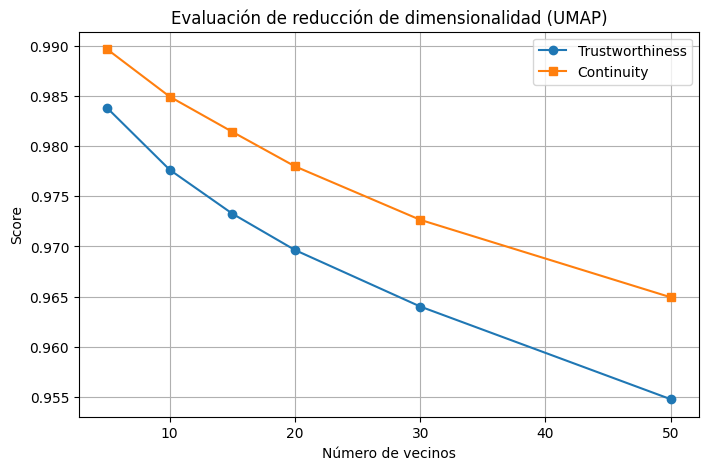

In [ ]:
X = X_train_scaled     # datos originales
Y = X_train_umap       # datos reducidos

n_samples = X.shape[0]

# Si tienes GPU:
X_gpu = cp.asarray(X)
Y_gpu = cp.asarray(Y)

# --- Lista de vecinos para evaluar ---
n_neighbors_list = [5, 10, 15, 20, 30, 50]

# --- Inicialización ---
trust_scores = {k: 0.0 for k in n_neighbors_list}
continuity_scores = {k: 0.0 for k in n_neighbors_list}
n_samples = X_gpu.shape[0]

print("🔹 Evaluando Trustworthiness y Continuity fila por fila...")

# --- Iterar sobre cada punto ---
for i in tqdm(range(n_samples)):
    # Distancias al resto de puntos
    dist_X = cp.linalg.norm(X_gpu - X_gpu[i], axis=1)
    dist_Y = cp.linalg.norm(Y_gpu - Y_gpu[i], axis=1)

    # Rangos
    rank_X = cp.argsort(dist_X)
    rank_Y = cp.argsort(dist_Y)

    for k in n_neighbors_list:
        # Vecinos en exceso
        ux = cp.setdiff1d(rank_Y[:k], rank_X[:k])
        uy = cp.setdiff1d(rank_X[:k], rank_Y[:k])

        # Sumas de posiciones corregidas
        trust_scores[k] += cp.sum(cp.array([cp.where(rank_X == int(j))[0][0] + 1 for j in ux]))
        continuity_scores[k] += cp.sum(cp.array([cp.where(rank_Y == int(j))[0][0] + 1 for j in uy]))

# --- Normalización ---
trustworthiness = {}
continuity = {}
for k in n_neighbors_list:
    denom = n_samples * k * (2*n_samples - 3*k -1)
    trustworthiness[k] = 1 - (2.0 / denom) * trust_scores[k].get()  # De GPU a CPU
    continuity[k] = 1 - (2.0 / denom) * continuity_scores[k].get()

# --- Resultados ---
print("\n📊 Resultados Trustworthiness y Continuity:")
for k in n_neighbors_list:
    print(f"{k:>3} vecinos -> Trustworthiness: {trustworthiness[k]:.4f}, Continuity: {continuity[k]:.4f}")

# --- Gráfico ---
plt.figure(figsize=(8,5))
plt.plot(list(trustworthiness.keys()), list(trustworthiness.values()), 'o-', label='Trustworthiness')
plt.plot(list(continuity.keys()), list(continuity.values()), 's-', label='Continuity')
plt.xlabel("Número de vecinos")
plt.ylabel("Score")
plt.title("Evaluación de reducción de dimensionalidad (UMAP)")
plt.grid(True)
plt.legend()
plt.show()


La figura muestra los valores de Trustworthiness y Continuity para UMAP, ambos superiores a 0.95, lo que indica una representación de alta calidad que conserva la estructura original de los datos. Con los parámetros (n_factors_umap = 32, n_neighbors = 15, min_dist = 0.1, metric = 'euclidean'), UMAP mantiene mejor las relaciones locales, algo apropiado para imágenes oculares, donde es esencial preservar los pequeños rasgos diferenciadores entre muestras.

#Red Neuronal Convolucional


In [ ]:
print(X_train_pca.shape, y_train.shape)
print(X_test_pca.shape, y_test.shape)


(5113, 128) (5113,)
(1279, 128) (1279,)


In [ ]:
print("Distribución en TRAIN:")
unique, counts = np.unique(y_train, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Clase {u}: {c}")

print("\nDistribución en TEST:")
unique, counts = np.unique(y_test, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Clase {u}: {c}")

Distribución en TRAIN:
Clase 0: 213
Clase 1: 234
Clase 2: 1286
Clase 3: 227
Clase 4: 103
Clase 5: 186
Clase 6: 2298
Clase 7: 566

Distribución en TEST:
Clase 0: 53
Clase 1: 59
Clase 2: 322
Clase 3: 57
Clase 4: 25
Clase 5: 46
Clase 6: 575
Clase 7: 142


In [ ]:
print(X_train_scaled.shape)
print(X_train_pca.shape)
print(y_train.shape)


(5113, 30000)
(5113, 128)
(5113,)


In [ ]:
print("X_train_scaled:", X_train_scaled.shape)
print("y_train:", y_train.shape)

print("X_test_scaled:", X_test_scaled.shape)
print("y_test:", y_test.shape)

print("X_train_pca:", X_train_pca.shape)
print("y_train:", y_train.shape)

print("Ejemplo de etiquetas:", y_train[:20])


X_train_scaled: (5113, 30000)
y_train: (5113,)
X_test_scaled: (1279, 30000)
y_test: (1279,)
X_train_pca: (5113, 128)
y_train: (5113,)
Ejemplo de etiquetas: [2 6 6 2 5 6 1 6 6 1 2 1 2 6 7 5 3 6 7 6]


In [ ]:
# ============================================================
# 🔹 FUNCIÓN 1: Construcción de la red neuronal CONVOLUCIONAL 1D
# ============================================================

def build_conv1d_model(input_length, num_classes):
    """
    Construye una CNN 1D para vectores reducidos (PCA, AF, UMAP).
    input_length = número de componentes/factores (ej: 32)
    num_classes  = número de diagnósticos a clasificar
    """

    # Entrada: un vector de tamaño input_length, pero CNN requiere canal → shape = (timesteps, channels)
    inp = layers.Input(shape=(input_length, 1))

    # Primera capa convolucional: detecta patrones locales en el vector
    x = layers.Conv1D(64, kernel_size=3, padding='same', activation='relu')(inp)
    x = layers.BatchNormalization()(x)  # Normaliza activaciones para entrenar mejor
    x = layers.MaxPooling1D(2)(x)       # Reduce la longitud a la mitad

    # Segunda capa convolucional: patrones más complejos
    x = layers.Conv1D(128, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)

    # Tercera capa convolucional
    x = layers.Conv1D(256, kernel_size=3, padding='same', activation='relu')(x)

    # Reduce el tensor a un vector (promedio por canal)
    x = layers.GlobalAveragePooling1D()(x)

    # Capa densa para aprendizaje profundo
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.4)(x)  # Evita sobreajuste

    # Capa final: una neurona por clase (softmax para clasificación)
    out = layers.Dense(num_classes, activation='softmax')(x)

    # Construcción del modelo
    model = models.Model(inputs=inp, outputs=out)
    return model


In [ ]:
# ============================================================
# 🔹 FUNCIÓN 2: Entrenamiento + Evaluación de la CNN 1D
# ============================================================

def train_eval_conv1d(X_train, X_test, y_train, y_test, tag="PCA",
                      epochs=80, batch_size=32, val_split=0.15, seed=42):
    """
    Entrena y evalúa la CNN 1D para un método de reducción.
    tag = 'PCA', 'AF' o 'UMAP'
    """

    # Para reproducibilidad
    np.random.seed(seed)
    tf.random.set_seed(seed)

    # Convertimos todos los datos a float32/int32 para que TensorFlow no falle
    X_train = np.asarray(X_train, dtype=np.float32)
    X_test = np.asarray(X_test, dtype=np.float32)
    y_train = np.asarray(y_train, dtype=np.int32)
    y_test = np.asarray(y_test, dtype=np.int32)

    # Número de componentes/factores
    n_components = X_train.shape[1]
    num_classes = len(np.unique(y_train))  # cuántas clases hay

    # Reshape obligatorio: Conv1D requiere (samples, timesteps, channels)
    X_train_c = X_train.reshape((-1, n_components, 1))
    X_test_c  = X_test.reshape((-1, n_components, 1))

    # -------------------------
    # ⚖️ Cálculo de pesos de clase (dataset desbalanceado)
    # -------------------------
    classes = np.unique(y_train)
    cw = compute_class_weight('balanced', classes=classes, y=y_train)
    class_weights = dict(enumerate(cw))
    print(f"[{tag}] class_weights:", class_weights)

    # -------------------------
    # 🔨 Construir el modelo
    # -------------------------
    model = build_conv1d_model(n_components, num_classes)

    # Compilación del modelo
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='sparse_categorical_crossentropy',   # usamos etiquetas numéricas
        metrics=['accuracy']
    )

    model.summary()  # imprime arquitectura de la red

    # -------------------------
    # Callbacks
    # -------------------------
    es = callbacks.EarlyStopping(monitor='val_loss', patience=8,
                                 restore_best_weights=True)
    rlr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                      patience=4)

    # -------------------------
    # 🚀 ENTRENAMIENTO
    # -------------------------
    history = model.fit(
        X_train_c, y_train,
        validation_split=val_split,  # 15% del train para validar
        epochs=epochs,
        batch_size=batch_size,
        class_weight=class_weights,  # corregir desbalance
        callbacks=[es, rlr],
        verbose=2
    )

    # -------------------------
    # 📊 Evaluación en test
    # -------------------------
    test_loss, test_acc = model.evaluate(X_test_c, y_test, verbose=0)

    # Predicción de clases
    y_pred_probs = model.predict(X_test_c)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Reporte de clasificación
    report = classification_report(y_test, y_pred, output_dict=True)

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)

    # Métrica principal
    f1_macro = f1_score(y_test, y_pred, average='macro')

    print(f"\n[{tag}] Test accuracy: {test_acc:.4f}, F1-macro: {f1_macro:.4f}")
    # -------------------------
    # 🔍 Gráficas de entrenamiento
    # -------------------------
    plt.figure(figsize=(12,4))

    # Curva de pérdida
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(f'{tag} - Loss')
    plt.legend()

    # Curva de precisión
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title(f'{tag} - Accuracy')
    plt.legend()

    plt.show()

    # -------------------------
    # 🔢 Matriz de confusión
    # -------------------------
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{tag} - Confusion matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Retornamos todo
    return {
        'model': model,
        'history': history,
        'report': report,
        'confusion_matrix': cm,
        'test_acc': test_acc,
        'f1_macro': f1_macro
    }


[PCA] class_weights: {0: np.float64(3.000586854460094), 1: np.float64(2.7313034188034186), 2: np.float64(0.4969867807153966), 3: np.float64(2.8155286343612334), 4: np.float64(6.205097087378641), 5: np.float64(3.4361559139784945), 6: np.float64(0.2781222802436902), 7: np.float64(1.129196113074205)}


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 32, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 16, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 16, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 8, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 8, 256)         │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 158,216 (618.03 KB)

 Trainable params: 157,832 (616.53 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/80
136/136 - 20s - 149ms/step - accuracy: 0.1415 - loss: 2.0521 - val_accuracy: 0.0965 - val_loss: 2.1044 - learning_rate: 1.0000e-03
Epoch 2/80
136/136 - 1s - 5ms/step - accuracy: 0.1629 - loss: 1.9243 - val_accuracy: 0.2164 - val_loss: 1.9466 - learning_rate: 1.0000e-03
Epoch 3/80
136/136 - 0s - 4ms/step - accuracy: 0.1627 - loss: 1.8396 - val_accuracy: 0.1904 - val_loss: 1.9074 - learning_rate: 1.0000e-03
Epoch 4/80
136/136 - 0s - 4ms/step - accuracy: 0.1783 - loss: 1.7696 - val_accuracy: 0.2164 - val_loss: 1.8692 - learning_rate: 1.0000e-03
Epoch 5/80
136/136 - 1s - 4ms/step - accuracy: 0.1652 - loss: 1.6929 - val_accuracy: 0.1825 - val_loss: 1.9129 - learning_rate: 1.0000e-03
Epoch 6/80
136/136 - 1s - 4ms/step - accuracy: 0.1664 - loss: 1.6433 - val_accuracy: 0.2047 - val_loss: 1.8283 - learning_rate: 1.0000e-03
Epoch 7/80
136/136 - 1s - 4ms/step - accuracy: 0.1889 - loss: 1.5848 - val_accuracy: 0.1760 - val_loss: 1.8383 - learning_rate: 1.0000e-03
Epoch 8/80
136/136 - 1s 

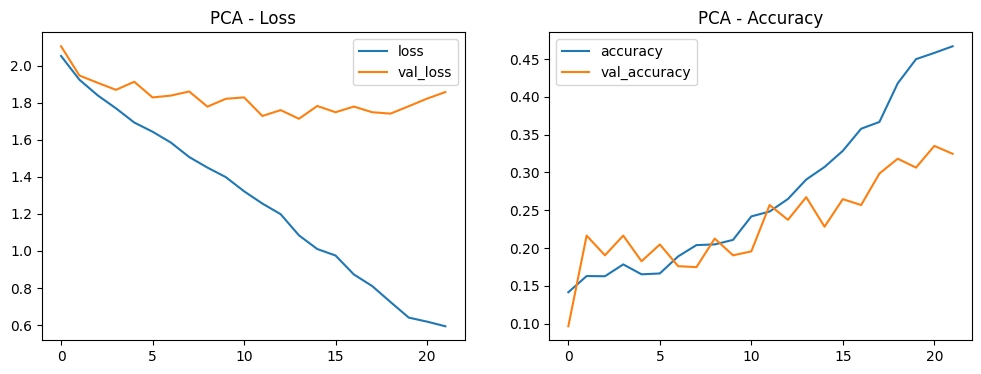

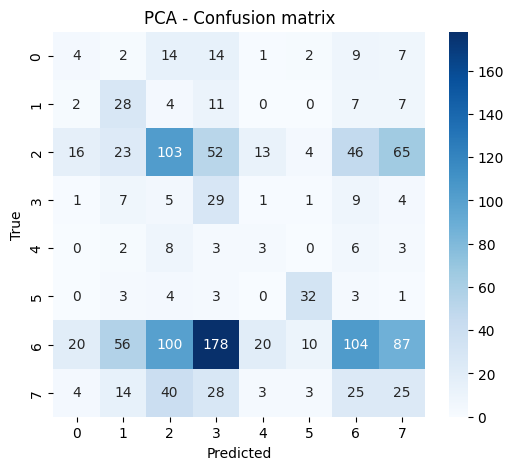

In [ ]:
# PCA
result_pca = train_eval_conv1d(X_train_pca, X_test_pca, y_train, y_test, tag="PCA")

[AF] class_weights: {0: np.float64(3.000586854460094), 1: np.float64(2.7313034188034186), 2: np.float64(0.4969867807153966), 3: np.float64(2.8155286343612334), 4: np.float64(6.205097087378641), 5: np.float64(3.4361559139784945), 6: np.float64(0.2781222802436902), 7: np.float64(1.129196113074205)}


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 32, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 16, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 16, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 8, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 8, 256)         │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 158,216 (618.03 KB)

 Trainable params: 157,832 (616.53 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/80
136/136 - 13s - 99ms/step - accuracy: 0.1394 - loss: 2.0801 - val_accuracy: 0.1252 - val_loss: 1.9630 - learning_rate: 1.0000e-03
Epoch 2/80
136/136 - 1s - 7ms/step - accuracy: 0.1335 - loss: 1.9649 - val_accuracy: 0.1121 - val_loss: 1.9515 - learning_rate: 1.0000e-03
Epoch 3/80
136/136 - 1s - 4ms/step - accuracy: 0.1581 - loss: 1.8600 - val_accuracy: 0.1708 - val_loss: 1.8427 - learning_rate: 1.0000e-03
Epoch 4/80
136/136 - 1s - 4ms/step - accuracy: 0.1592 - loss: 1.7764 - val_accuracy: 0.2412 - val_loss: 1.8101 - learning_rate: 1.0000e-03
Epoch 5/80
136/136 - 1s - 4ms/step - accuracy: 0.1813 - loss: 1.6673 - val_accuracy: 0.1721 - val_loss: 1.8581 - learning_rate: 1.0000e-03
Epoch 6/80
136/136 - 1s - 4ms/step - accuracy: 0.1924 - loss: 1.5911 - val_accuracy: 0.1969 - val_loss: 1.8212 - learning_rate: 1.0000e-03
Epoch 7/80
136/136 - 1s - 4ms/step - accuracy: 0.2200 - loss: 1.4615 - val_accuracy: 0.2177 - val_loss: 1.8198 - learning_rate: 1.0000e-03
Epoch 8/80
136/136 - 1s -

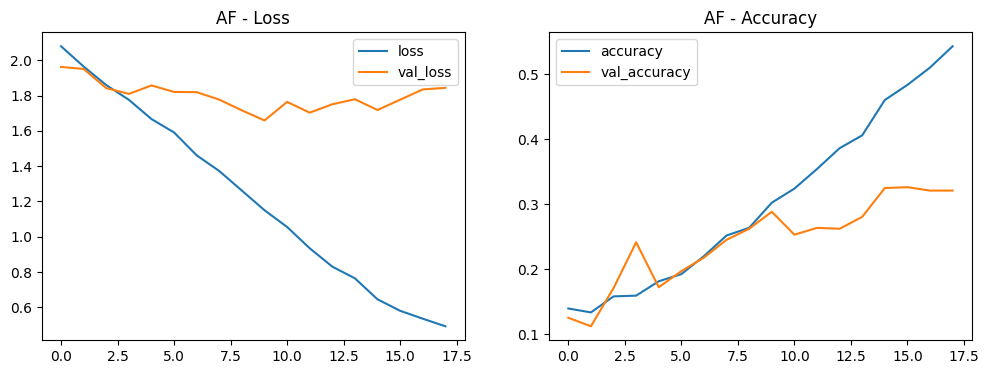

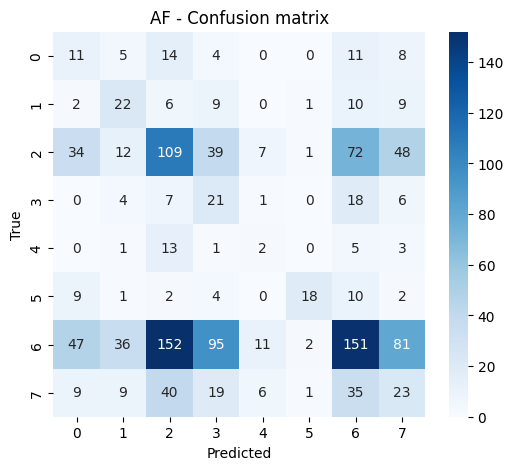

In [ ]:
#AF
result_af  = train_eval_conv1d(X_train_af, X_test_af, y_train, y_test, tag="AF")

[UMAP] class_weights: {0: np.float64(3.000586854460094), 1: np.float64(2.7313034188034186), 2: np.float64(0.4969867807153966), 3: np.float64(2.8155286343612334), 4: np.float64(6.205097087378641), 5: np.float64(3.4361559139784945), 6: np.float64(0.2781222802436902), 7: np.float64(1.129196113074205)}


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 32, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 16, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 16, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 8, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 8, 256)         │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 158,216 (618.03 KB)

 Trainable params: 157,832 (616.53 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/80
136/136 - 12s - 87ms/step - accuracy: 0.1127 - loss: 2.0734 - val_accuracy: 0.0665 - val_loss: 2.0814 - learning_rate: 1.0000e-03
Epoch 2/80
136/136 - 2s - 16ms/step - accuracy: 0.1077 - loss: 2.0282 - val_accuracy: 0.1056 - val_loss: 2.0439 - learning_rate: 1.0000e-03
Epoch 3/80
136/136 - 1s - 4ms/step - accuracy: 0.0902 - loss: 2.0012 - val_accuracy: 0.0821 - val_loss: 2.0276 - learning_rate: 1.0000e-03
Epoch 4/80
136/136 - 1s - 4ms/step - accuracy: 0.0939 - loss: 1.9799 - val_accuracy: 0.1199 - val_loss: 1.9967 - learning_rate: 1.0000e-03
Epoch 5/80
136/136 - 1s - 4ms/step - accuracy: 0.0978 - loss: 1.9725 - val_accuracy: 0.1825 - val_loss: 1.9685 - learning_rate: 1.0000e-03
Epoch 6/80
136/136 - 1s - 4ms/step - accuracy: 0.1035 - loss: 1.9664 - val_accuracy: 0.1252 - val_loss: 1.9825 - learning_rate: 1.0000e-03
Epoch 7/80
136/136 - 1s - 4ms/step - accuracy: 0.1017 - loss: 1.9431 - val_accuracy: 0.1317 - val_loss: 1.9900 - learning_rate: 1.0000e-03
Epoch 8/80
136/136 - 1s 

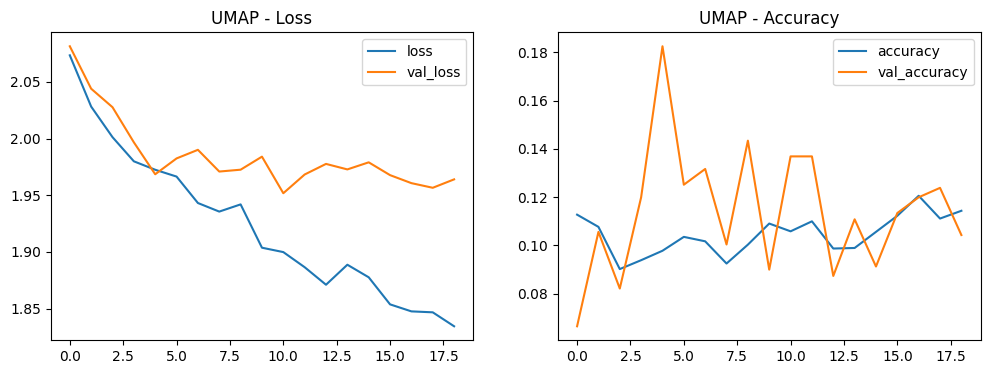

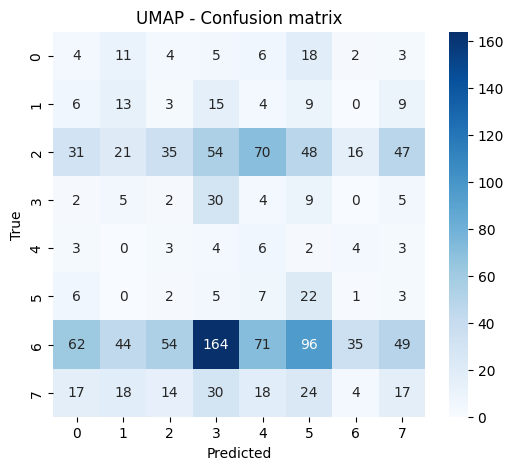

In [ ]:
#UMAP
result_umap = train_eval_conv1d(X_train_umap, X_test_umap, y_train, y_test, tag="UMAP")

#Smote para balanceo de datos

In [ ]:
sm = SMOTE(random_state=42)

X_train_pca_sm, y_train_pca_sm = sm.fit_resample(X_train_pca, y_train)
X_train_af_sm, y_train_af_sm = sm.fit_resample(X_train_af, y_train)
X_train_umap_sm, y_train_umap_sm = sm.fit_resample(X_train_umap, y_train)

In [ ]:
print("Distribución original:", np.bincount(y_train))
print("Distribución SMOTE:", np.bincount(y_train_pca_sm))

Distribución original: [ 213  234 1286  227  103  186 2298  566]
Distribución SMOTE: [2298 2298 2298 2298 2298 2298 2298 2298]


# Balanceo de datos con class_weight

In [ ]:
def calcular_class_weights(y_train):
    clases = np.unique(y_train)
    pesos = compute_class_weight(
        class_weight='balanced',
        classes=clases,
        y=y_train
    )
    return dict(zip(clases, pesos))

# Red Densa

In [ ]:
i = 0  # revisión de relación entre nombre y diagnostico en pca

print("Índice verificado:", i)
print("Nombre de imagen  :", filenames_train[i])
print("Etiqueta           :", y_train[i])
print("Primeros 5 pixeles :", datos_aplanados_train[i][:5])
print("Primeros 5 PCA     :", X_train_pca[i][:5])


Índice verificado: 0
Nombre de imagen  : 4045_left.jpg
Etiqueta           : 2
Primeros 5 pixeles : [0 0 0 0 0]
Primeros 5 PCA     : [-140.19073319  -11.70427191    5.88968662   15.82072076  -16.25282315]


In [ ]:
# 1. Obtener la imagen original
x_orig = datos_aplanados_train[i].reshape(1, -1)

# 2. Escalarla igual que el dataset
x_scaled = scaler.transform(x_orig)

# 3. Aplicar SVD
pca_manual = svd.transform(x_scaled)[0]

print("PCA recalculado:", pca_manual[:5])
print("PCA almacenado :", X_train_pca[i][:5])


PCA recalculado: [-140.19073319  -11.70427191    5.88968662   15.82072076  -16.25282315]
PCA almacenado : [-140.19073319  -11.70427191    5.88968662   15.82072076  -16.25282315]


### Red con balanceo de datos (smoot)

In [ ]:
def crear_red_densa(n_features, n_classes):
    from tensorflow.keras import layers, models

    modelo = models.Sequential([
        layers.Input(shape=(n_features,)),

        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(64, activation='relu'),

        layers.Dense(n_classes, activation='softmax')
    ])

    modelo.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return modelo


In [ ]:
def entrenar_red_densa(X_train, y_train, X_test, y_test, n_features, titulo="Modelo"):

    print("===================================================")
    print(f" ENTRENANDO: {titulo}")
    print("===================================================")

    modelo = crear_red_densa(
        n_features=n_features,
        n_classes=len(np.unique(y_train))
    )

    hist = modelo.fit(
        X_train,
        y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        verbose=1
    )

    # ========================
    # Evaluación en test
    # ========================
    loss, acc = modelo.evaluate(X_test, y_test, verbose=0)
    print("\n================================")
    print(f" ACCURACY TEST ({titulo}): {acc}")
    print(f" LOSS TEST ({titulo}):     {loss}")
    print("================================\n")

    # ========================
    # Curvas
    # ========================
    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title(f"Pérdida - {titulo}")
    plt.xlabel("Épocas")
    plt.ylabel("Loss")
    plt.legend(["train", "val"])

    plt.subplot(1,2,2)
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title(f"Accuracy - {titulo}")
    plt.xlabel("Épocas")
    plt.ylabel("Accuracy")
    plt.legend(["train", "val"])

    plt.show()

    # ========================
    # Matriz de confusión
    # ========================
    y_pred = modelo.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)

    print(classification_report(y_test, y_pred_labels))

    cm = confusion_matrix(y_test, y_pred_labels)

    plt.figure(figsize=(10,8))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues"
    )
    plt.title(f"Matriz de Confusión - {titulo}", fontsize=16)
    plt.xlabel("Predicción", fontsize=12)
    plt.ylabel("Real", fontsize=12)
    plt.show()

    return modelo


 ENTRENANDO: PCA + Red Densa
Epoch 1/50
460/460 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.3054 - loss: 1.9161 - val_accuracy: 0.2720 - val_loss: 2.2638
Epoch 2/50
460/460 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4635 - loss: 1.4636 - val_accuracy: 0.3454 - val_loss: 2.0477
Epoch 3/50
460/460 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5154 - loss: 1.3299 - val_accuracy: 0.3533 - val_loss: 2.0305
Epoch 4/50
460/460 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5608 - loss: 1.1975 - val_accuracy: 0.3818 - val_loss: 1.8853
Epoch 5/50
460/460 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5880 - loss: 1.1335 - val_accuracy: 0.4017 - val_loss: 1.7485
Epoch 6/50
460/460 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6095 - loss: 1.0739 - val_accuracy: 0.3881 - val_loss: 1.8970
Epoch 7/50
460/460 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6254 - loss: 1.0258 - val_accuracy: 0.4145 - val_loss: 1.7150
Epoch 8/50
460/460 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6379 - lo

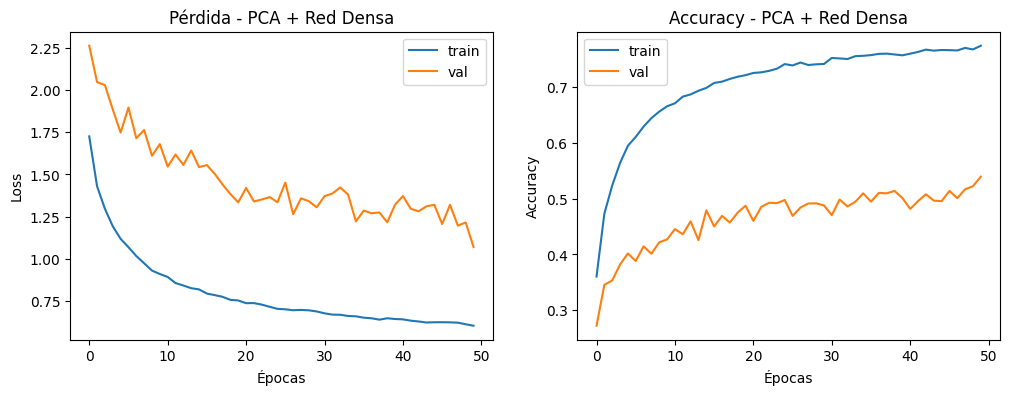

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
              precision    recall  f1-score   support

           0       0.05      0.08      0.06        53
           1       0.40      0.51      0.45        59
           2       0.34      0.47      0.39       322
           3       0.12      0.30      0.17        57
           4       0.06      0.16      0.09        25
           5       0.61      0.72      0.66        46
           6       0.55      0.37      0.44       575
           7       0.27      0.04      0.07       142

    accuracy                           0.36      1279
   macro avg       0.30      0.33      0.29      1279
weighted avg       0.41      0.36      0.36      1279



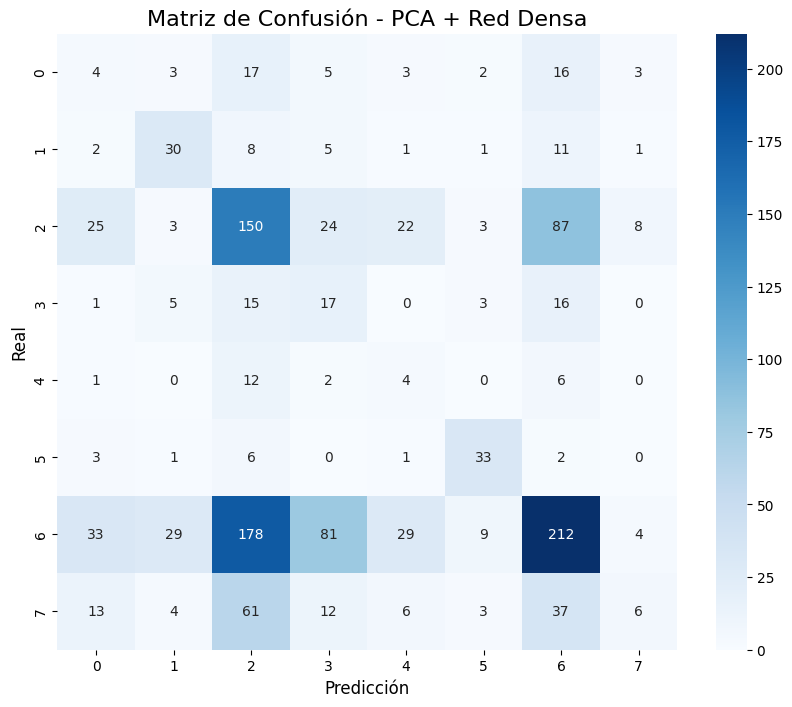

In [ ]:
modelo_pca = entrenar_red_densa(
    X_train_pca_sm,
    y_train_pca_sm,
    X_test_pca,
    y_test,
    n_features=X_train_pca_sm.shape[1],
    titulo="PCA + Red Densa"
)


 ENTRENANDO: Factor Analysis + Red Densa
Epoch 1/50
460/460 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.3495 - loss: 1.8383 - val_accuracy: 0.3264 - val_loss: 2.0991
Epoch 2/50
460/460 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.5240 - loss: 1.2967 - val_accuracy: 0.3312 - val_loss: 2.1187
Epoch 3/50
460/460 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5878 - loss: 1.1323 - val_accuracy: 0.3661 - val_loss: 1.9241
Epoch 4/50
460/460 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6242 - loss: 1.0291 - val_accuracy: 0.3949 - val_loss: 1.8319
Epoch 5/50
460/460 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6478 - loss: 0.9523 - val_accuracy: 0.3943 - val_loss: 1.7983
Epoch 6/50
460/460 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6759 - loss: 0.8853 - val_accuracy: 0.4468 - val_loss: 1.6547
Epoch 7/50
460/460 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6836 - loss: 0.8505 - val_accuracy: 0.4534 - val_loss: 1.5612
Epoch 8/50
460/460 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - acc

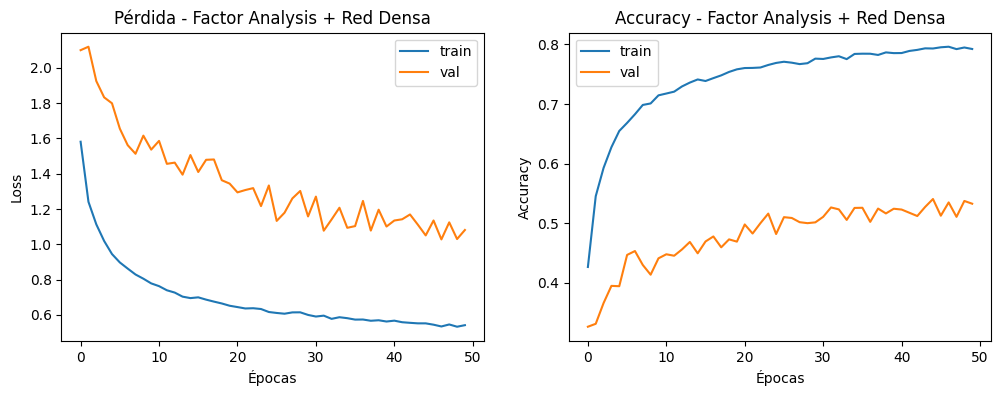

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
              precision    recall  f1-score   support

           0       0.08      0.13      0.10        53
           1       0.46      0.51      0.48        59
           2       0.34      0.48      0.40       322
           3       0.10      0.19      0.13        57
           4       0.09      0.20      0.13        25
           5       0.64      0.65      0.65        46
           6       0.52      0.41      0.45       575
           7       0.22      0.01      0.03       142

    accuracy                           0.37      1279
   macro avg       0.31      0.32      0.30      1279
weighted avg       0.40      0.37      0.37      1279



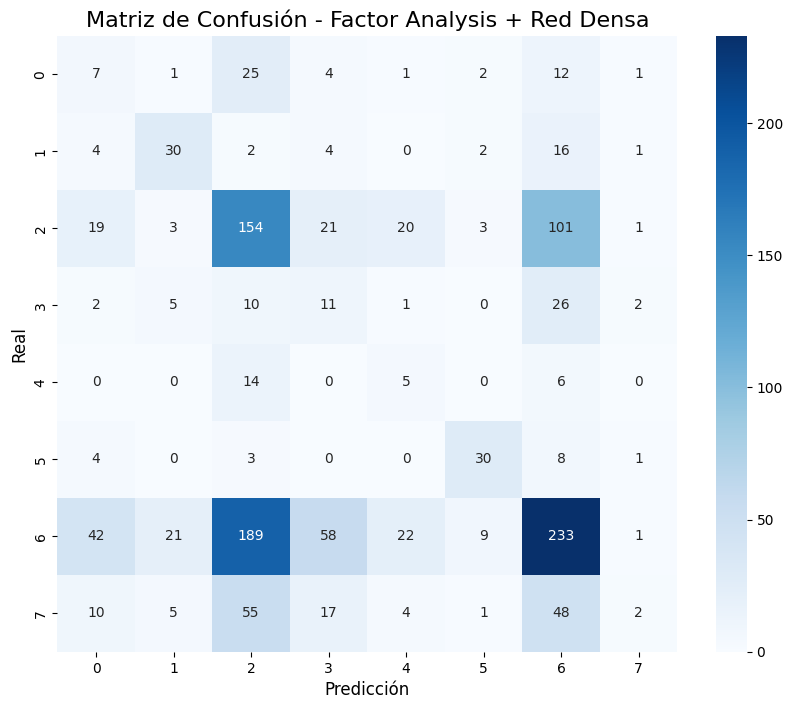

In [ ]:
modelo_af = entrenar_red_densa(
    X_train_af_sm,
    y_train_af_sm,
    X_test_af,
    y_test,
    n_features=X_train_af_sm.shape[1],
    titulo="Factor Analysis + Red Densa"
)


 ENTRENANDO: UMAP + Red Densa
Epoch 1/50
460/460 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.2259 - loss: 2.0517 - val_accuracy: 0.0000e+00 - val_loss: 3.0072
Epoch 2/50
460/460 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2820 - loss: 1.8393 - val_accuracy: 0.0000e+00 - val_loss: 3.5001
Epoch 3/50
460/460 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2950 - loss: 1.7942 - val_accuracy: 0.0000e+00 - val_loss: 3.1300
Epoch 4/50
460/460 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3008 - loss: 1.7809 - val_accuracy: 0.0000e+00 - val_loss: 3.2504
Epoch 5/50
460/460 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3141 - loss: 1.7604 - val_accuracy: 0.0000e+00 - val_loss: 3.4009
Epoch 6/50
460/460 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3139 - loss: 1.7532 - val_accuracy: 0.0000e+00 - val_loss: 3.4095
Epoch 7/50
460/460 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3063 - loss: 1.7573 - val_accuracy: 0.0000e+00 - val_loss: 3.2834
Epoch 8/50
460/460 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms

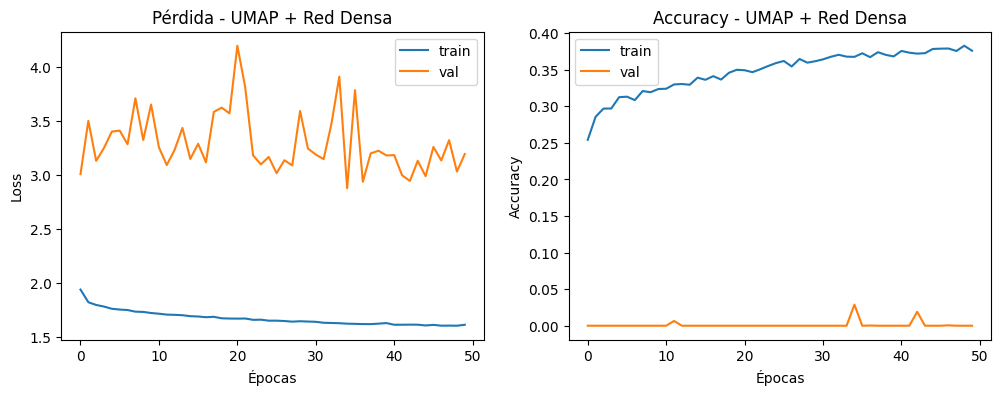

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
              precision    recall  f1-score   support

           0       0.03      0.09      0.05        53
           1       0.10      0.31      0.15        59
           2       0.29      0.32      0.30       322
           3       0.08      0.51      0.14        57
           4       0.02      0.12      0.04        25
           5       0.00      0.00      0.00        46
           6       0.58      0.09      0.15       575
           7       0.00      0.00      0.00       142

    accuracy                           0.16      1279
   macro avg       0.14      0.18      0.10      1279
weighted avg       0.34      0.16      0.16      1279



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


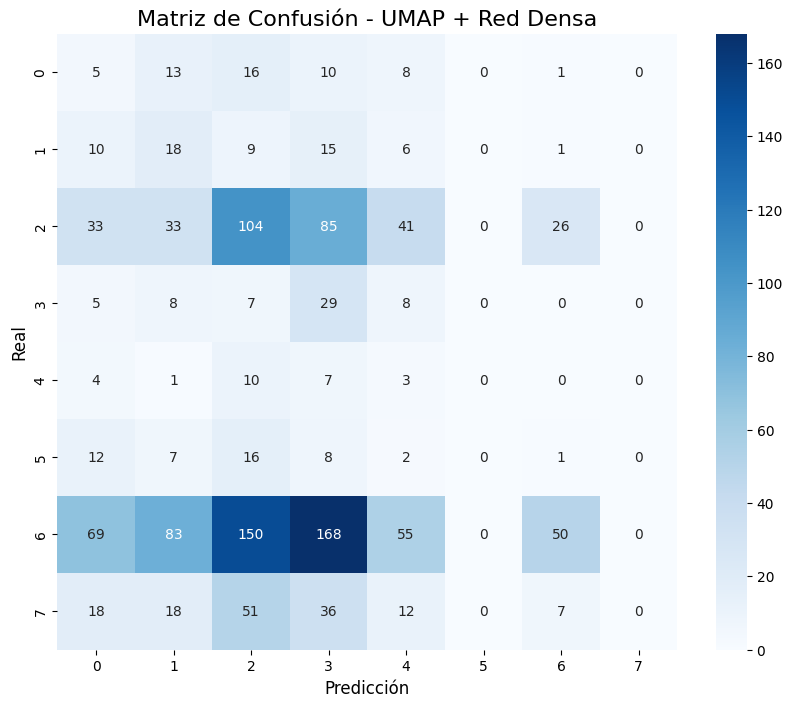

In [ ]:
modelo_umap = entrenar_red_densa(
    X_train_umap_sm,
    y_train_umap_sm,
    X_test_umap,
    y_test,
    n_features=X_train_umap_sm.shape[1],
    titulo="UMAP + Red Densa"
)


# Perceptrón Multicapa

## Creación del modelo

In [ ]:
def crear_mlp_profundo(n_features, n_classes):

    modelo = models.Sequential([
        layers.Input(shape=(n_features,)),

        layers.Dense(
            256,
            activation='gelu',
            kernel_initializer=initializers.HeNormal(),
            kernel_regularizer=regularizers.l2(1e-4)
        ),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(
            128,
            activation='gelu',
            kernel_initializer=initializers.HeNormal(),
            kernel_regularizer=regularizers.l2(1e-4)
        ),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(
            64,
            activation='gelu',
            kernel_initializer=initializers.HeNormal(),
            kernel_regularizer=regularizers.l2(1e-4)
        ),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        layers.Dense(
            32,
            activation='gelu',
            kernel_initializer=initializers.HeNormal(),
            kernel_regularizer=regularizers.l2(1e-4)
        ),
        layers.BatchNormalization(),

        layers.Dense(n_classes, activation='softmax')
    ])

    modelo.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return modelo

## Entrenamiento del modelo sin balance de los datos

In [ ]:
def entrenar_y_evaluar_sin_balanceo(X_train, y_train, X_test, y_test, titulo):

    n_features = X_train.shape[1]
    n_classes = len(np.unique(y_train))

    modelo = crear_mlp_profundo(n_features, n_classes)

    early_stop = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True
    )

    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=7,
        min_lr=1e-6
    )

    print(f"\n=== Entrenando modelo para: {titulo} ===\n")

    hist = modelo.fit(
        X_train,
        y_train,
        epochs=150,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )

    # ===== Evaluación =====
    loss, acc = modelo.evaluate(X_test, y_test, verbose=0)

    print("\n================================")
    print(f" ACCURACY TEST ({titulo}): {acc:.4f}")
    print(f" LOSS TEST ({titulo}):     {loss:.4f}")
    print("================================\n")

    # ===== Curvas =====
    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title(f"Pérdida - {titulo}")
    plt.xlabel("Épocas")
    plt.ylabel("Loss")
    plt.legend(["train", "val"])

    plt.subplot(1,2,2)
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title(f"Accuracy - {titulo}")
    plt.xlabel("Épocas")
    plt.ylabel("Accuracy")
    plt.legend(["train", "val"])

    plt.show()

    # ===== Matriz de confusión =====
    y_pred = modelo.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)

    print(classification_report(y_test, y_pred_labels))

    cm = confusion_matrix(y_test, y_pred_labels)

    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Matriz de Confusión - {titulo}")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()

    return modelo



=== Entrenando modelo para: PCA + MLP ===

Epoch 1/150
128/128 ━━━━━━━━━━━━━━━━━━━━ 23s 85ms/step - accuracy: 0.1843 - loss: 2.5047 - val_accuracy: 0.3304 - val_loss: 2.0119 - learning_rate: 0.0010
Epoch 2/150
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3512 - loss: 1.9143 - val_accuracy: 0.4633 - val_loss: 1.6429 - learning_rate: 0.0010
Epoch 3/150
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4107 - loss: 1.7438 - val_accuracy: 0.4731 - val_loss: 1.5633 - learning_rate: 0.0010
Epoch 4/150
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4423 - loss: 1.6142 - val_accuracy: 0.4790 - val_loss: 1.5406 - learning_rate: 0.0010
Epoch 5/150
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4586 - loss: 1.5916 - val_accuracy: 0.4712 - val_loss: 1.5268 - learning_rate: 0.0010
Epoch 6/150
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4582 - loss: 1.5578 - val_accuracy: 0.4848 - val_loss: 1.5101 - learning_rate: 0.0010
Epoch 7/150
128/128 ━━━━━━━━━━━━━━━━

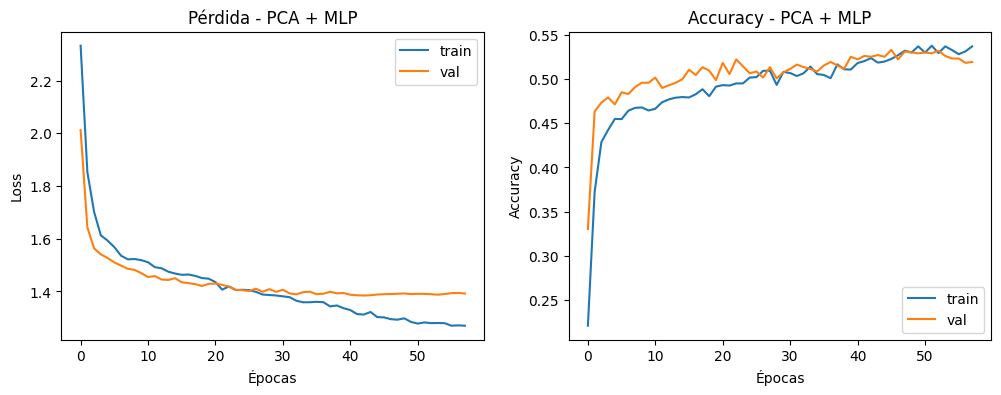

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        53
           1       0.38      0.17      0.24        59
           2       0.37      0.29      0.32       322
           3       0.50      0.07      0.12        57
           4       0.33      0.08      0.13        25
           5       0.74      0.57      0.64        46
           6       0.49      0.81      0.61       575
           7       0.29      0.03      0.05       142

    accuracy                           0.47      1279
   macro avg       0.39      0.25      0.26      1279
weighted avg       0.42      0.47      0.40      1279



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


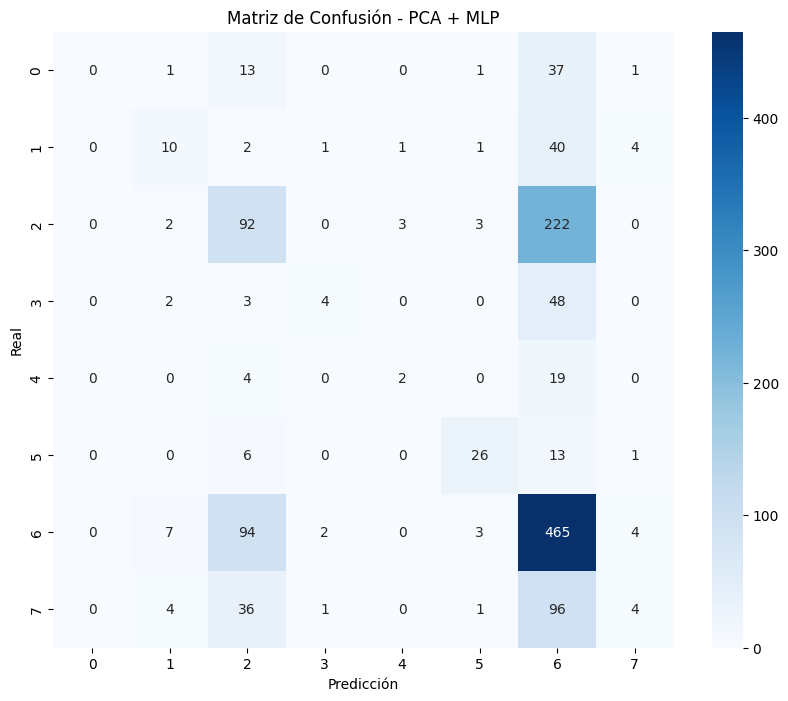

In [ ]:
modelo_pca = entrenar_y_evaluar_sin_balanceo(
    X_train_pca, y_train,
    X_test_pca, y_test,
    "PCA + MLP"
)


=== Entrenando modelo para: FA + MLP ===

Epoch 1/150
128/128 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - accuracy: 0.1755 - loss: 2.4933 - val_accuracy: 0.4174 - val_loss: 1.8986 - learning_rate: 0.0010
Epoch 2/150
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3339 - loss: 1.9710 - val_accuracy: 0.4741 - val_loss: 1.6755 - learning_rate: 0.0010
Epoch 3/150
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4261 - loss: 1.7223 - val_accuracy: 0.4682 - val_loss: 1.5903 - learning_rate: 0.0010
Epoch 4/150
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4566 - loss: 1.5949 - val_accuracy: 0.4809 - val_loss: 1.5443 - learning_rate: 0.0010
Epoch 5/150
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4389 - loss: 1.5847 - val_accuracy: 0.4809 - val_loss: 1.5196 - learning_rate: 0.0010
Epoch 6/150
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4583 - loss: 1.5570 - val_accuracy: 0.4956 - val_loss: 1.4926 - learning_rate: 0.0010
Epoch 7/150
128/128 ━━━━━━━━━━━━━━━━━

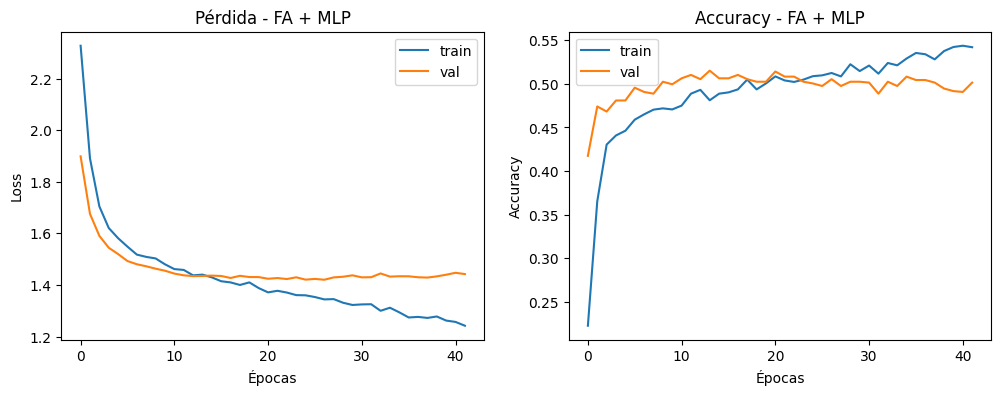

40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        53
           1       0.54      0.32      0.40        59
           2       0.42      0.30      0.35       322
           3       0.13      0.04      0.06        57
           4       0.40      0.08      0.13        25
           5       0.83      0.63      0.72        46
           6       0.50      0.83      0.63       575
           7       0.50      0.02      0.04       142

    accuracy                           0.49      1279
   macro avg       0.42      0.28      0.29      1279
weighted avg       0.46      0.49      0.42      1279



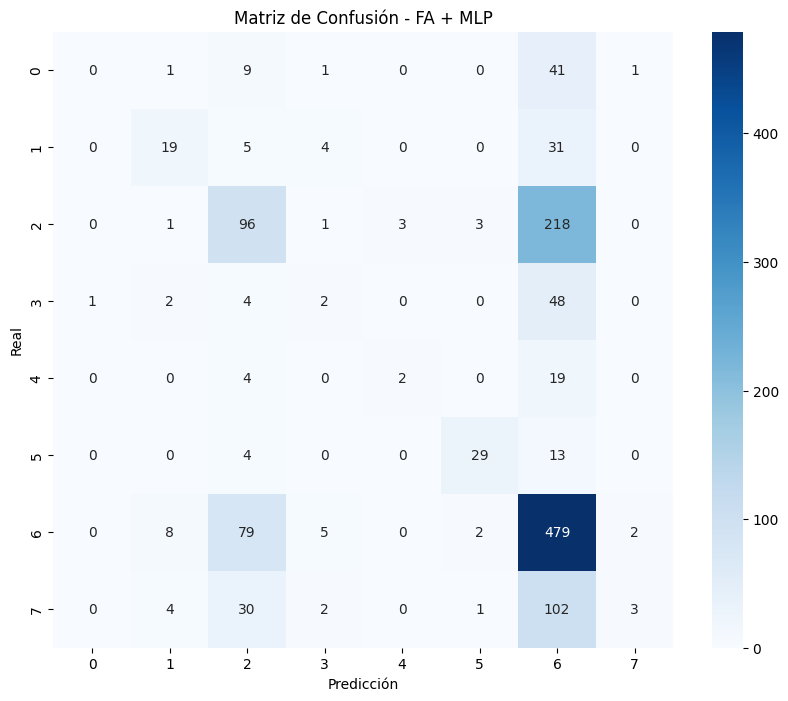

In [ ]:
modelo_af = entrenar_y_evaluar_sin_balanceo(
    X_train_af, y_train,
    X_test_af, y_test,
    "FA + MLP"
)


=== Entrenando modelo para: UMAP + MLP ===

Epoch 1/150
128/128 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - accuracy: 0.1623 - loss: 2.4926 - val_accuracy: 0.1916 - val_loss: 2.1574 - learning_rate: 0.0010
Epoch 2/150
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3241 - loss: 1.9532 - val_accuracy: 0.4360 - val_loss: 1.7104 - learning_rate: 0.0010
Epoch 3/150
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4244 - loss: 1.7304 - val_accuracy: 0.4418 - val_loss: 1.6481 - learning_rate: 0.0010
Epoch 4/150
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4481 - loss: 1.6649 - val_accuracy: 0.4526 - val_loss: 1.6225 - learning_rate: 0.0010
Epoch 5/150
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4380 - loss: 1.6418 - val_accuracy: 0.4585 - val_loss: 1.6127 - learning_rate: 0.0010
Epoch 6/150
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4420 - loss: 1.6600 - val_accuracy: 0.4721 - val_loss: 1.6223 - learning_rate: 0.0010
Epoch 7/150
128/128 ━━━━━━━━━━━━━━━

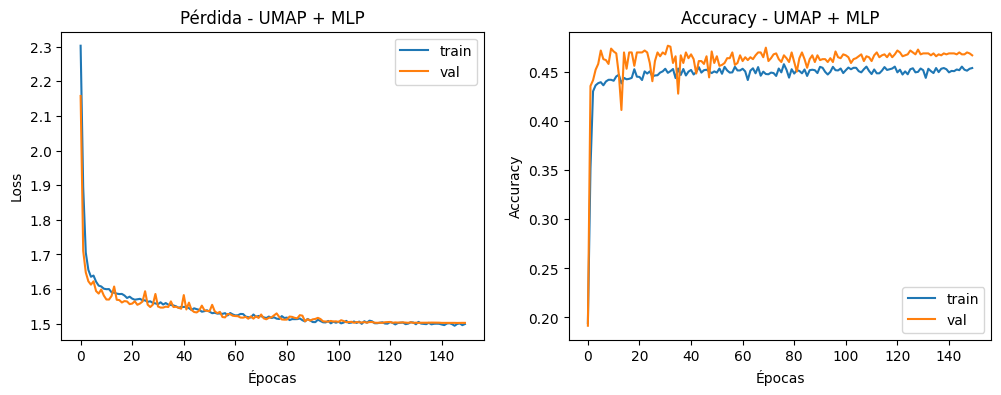

40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        53
           1       0.00      0.00      0.00        59
           2       0.39      0.11      0.17       322
           3       0.00      0.00      0.00        57
           4       0.00      0.00      0.00        25
           5       0.00      0.00      0.00        46
           6       0.46      0.95      0.62       575
           7       0.00      0.00      0.00       142

    accuracy                           0.46      1279
   macro avg       0.11      0.13      0.10      1279
weighted avg       0.30      0.46      0.32      1279



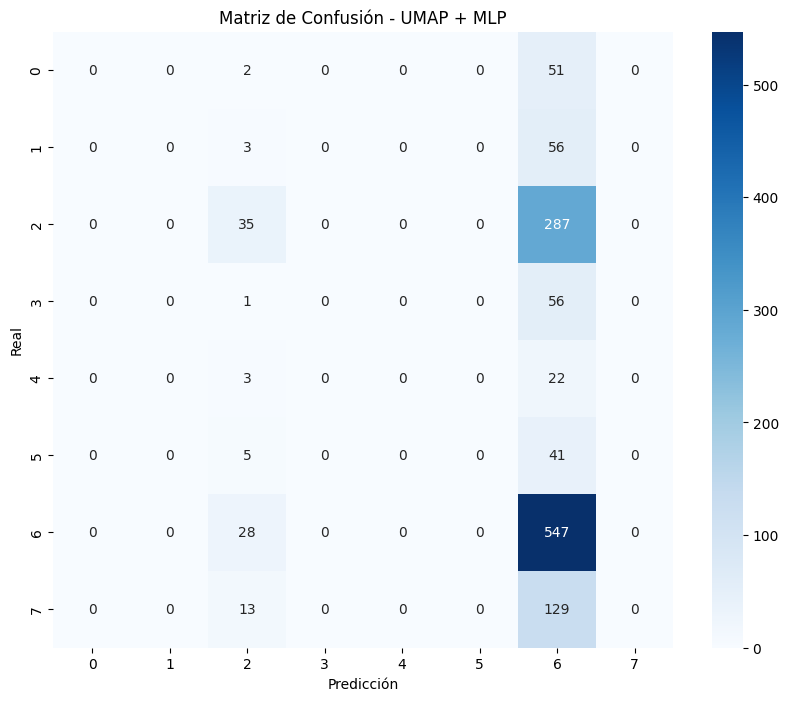

In [ ]:
modelo_umap = entrenar_y_evaluar_sin_balanceo(
    X_train_umap, y_train,
    X_test_umap, y_test,
    "UMAP + MLP"
)

## Entrenamiento del modelo con smoot

In [ ]:
def entrenar_y_evaluar(X_train, y_train, X_test, y_test, titulo):

    n_features = X_train.shape[1]
    n_classes = len(np.unique(y_train))

    modelo = crear_mlp_profundo(n_features, n_classes)

    # Callbacks
    early_stop = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True
    )

    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=7,
        min_lr=1e-6
    )

    print(f"\n=== Entrenando modelo para: {titulo} ===\n")

    hist = modelo.fit(
        X_train,
        y_train,
        epochs=120,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )

    # ---------- Evaluación ----------
    loss, acc = modelo.evaluate(X_test, y_test, verbose=0)
    print("\n================================")
    print(f" ACCURACY TEST ({titulo}):", acc)
    print(f" LOSS TEST ({titulo}):    ", loss)
    print("================================\n")

    # Curvas de entrenamiento
    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title(f"Pérdida - {titulo}")
    plt.xlabel("Épocas")
    plt.ylabel("Loss")
    plt.legend(["train", "val"])

    plt.subplot(1,2,2)
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title(f"Accuracy - {titulo}")
    plt.xlabel("Épocas")
    plt.ylabel("Accuracy")
    plt.legend(["train", "val"])

    plt.show()

    # Matriz de confusión
    y_pred = modelo.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)

    print(classification_report(y_test, y_pred_labels))

    cm = confusion_matrix(y_test, y_pred_labels)

    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Matriz de Confusión - {titulo}", fontsize=16)
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()

    return modelo



=== Entrenando modelo para: PCA + MLP ===

Epoch 1/120
460/460 ━━━━━━━━━━━━━━━━━━━━ 28s 35ms/step - accuracy: 0.2320 - loss: 2.2488 - val_accuracy: 0.0865 - val_loss: 2.7676 - learning_rate: 0.0010
Epoch 2/120
460/460 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.3669 - loss: 1.7654 - val_accuracy: 0.2638 - val_loss: 2.5263 - learning_rate: 0.0010
Epoch 3/120
460/460 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.4331 - loss: 1.6320 - val_accuracy: 0.2597 - val_loss: 2.5313 - learning_rate: 0.0010
Epoch 4/120
460/460 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4604 - loss: 1.5474 - val_accuracy: 0.3079 - val_loss: 2.3771 - learning_rate: 0.0010
Epoch 5/120
460/460 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4923 - loss: 1.4682 - val_accuracy: 0.3190 - val_loss: 2.3327 - learning_rate: 0.0010
Epoch 6/120
460/460 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5259 - loss: 1.4024 - val_accuracy: 0.3372 - val_loss: 2.2286 - learning_rate: 0.0010
Epoch 7/120
460/460 ━━━━━━━━━━━━━━━━

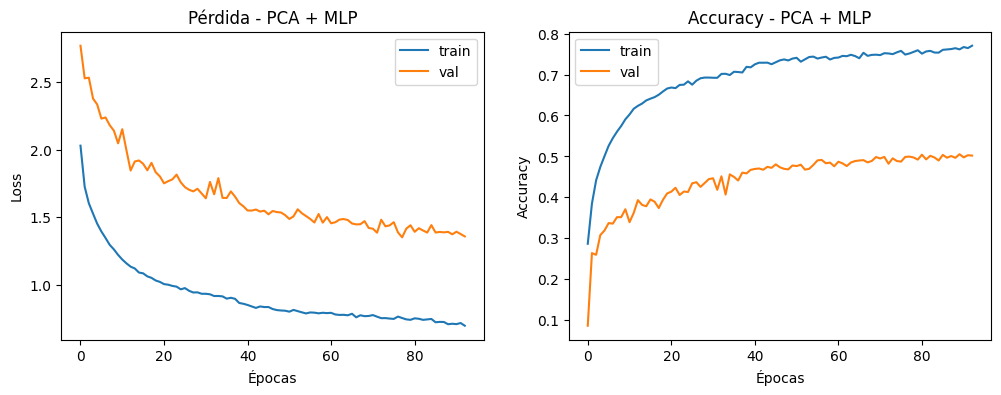

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
              precision    recall  f1-score   support

           0       0.05      0.06      0.05        53
           1       0.38      0.58      0.46        59
           2       0.34      0.53      0.41       322
           3       0.13      0.26      0.18        57
           4       0.05      0.12      0.07        25
           5       0.74      0.63      0.68        46
           6       0.53      0.38      0.44       575
           7       1.00      0.01      0.01       142

    accuracy                           0.37      1279
   macro avg       0.40      0.32      0.29      1279
weighted avg       0.49      0.37      0.36      1279



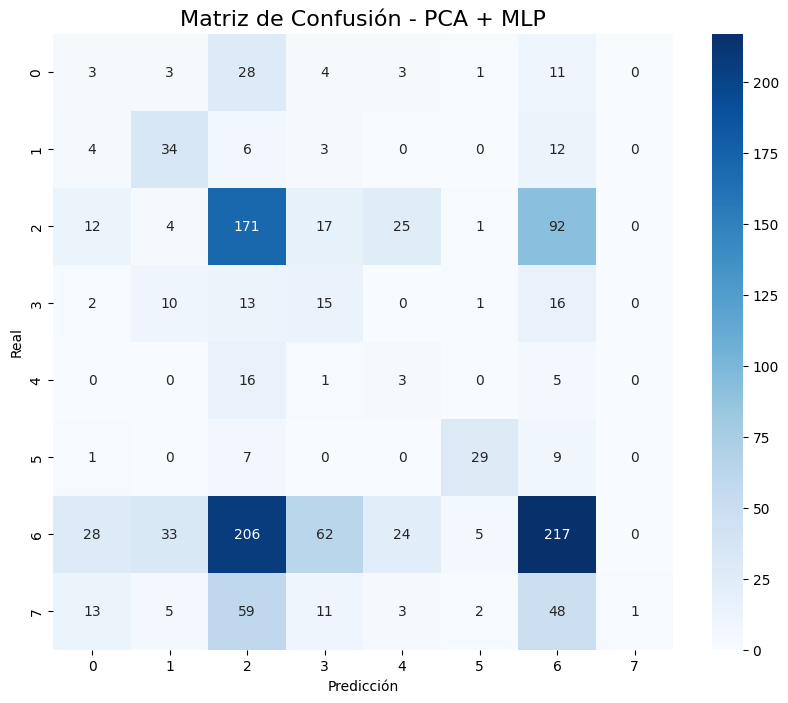

In [ ]:
modelo_pca = entrenar_y_evaluar(X_train_pca_sm, y_train_pca_sm,
                                X_test_pca, y_test,
                                "PCA + MLP")


=== Entrenando modelo para: FA + MLP ===

Epoch 1/120
460/460 ━━━━━━━━━━━━━━━━━━━━ 25s 28ms/step - accuracy: 0.2720 - loss: 2.1604 - val_accuracy: 0.0794 - val_loss: 2.6821 - learning_rate: 0.0010
Epoch 2/120
460/460 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.4547 - loss: 1.5727 - val_accuracy: 0.2377 - val_loss: 2.5590 - learning_rate: 0.0010
Epoch 3/120
460/460 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5014 - loss: 1.4504 - val_accuracy: 0.3000 - val_loss: 2.4709 - learning_rate: 0.0010
Epoch 4/120
460/460 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5589 - loss: 1.3240 - val_accuracy: 0.3147 - val_loss: 2.3293 - learning_rate: 0.0010
Epoch 5/120
460/460 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5699 - loss: 1.2865 - val_accuracy: 0.3266 - val_loss: 2.3029 - learning_rate: 0.0010
Epoch 6/120
460/460 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5786 - loss: 1.2409 - val_accuracy: 0.3204 - val_loss: 2.3418 - learning_rate: 0.0010
Epoch 7/120
460/460 ━━━━━━━━━━━━━━━━━

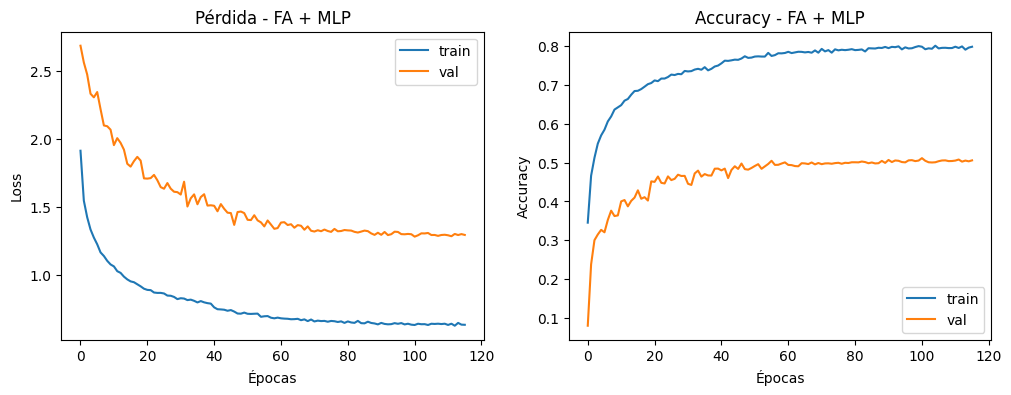

40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
              precision    recall  f1-score   support

           0       0.10      0.08      0.08        53
           1       0.42      0.49      0.45        59
           2       0.34      0.54      0.42       322
           3       0.12      0.23      0.16        57
           4       0.06      0.16      0.09        25
           5       0.59      0.63      0.61        46
           6       0.52      0.40      0.45       575
           7       0.50      0.01      0.01       142

    accuracy                           0.38      1279
   macro avg       0.33      0.32      0.28      1279
weighted avg       0.43      0.38      0.36      1279



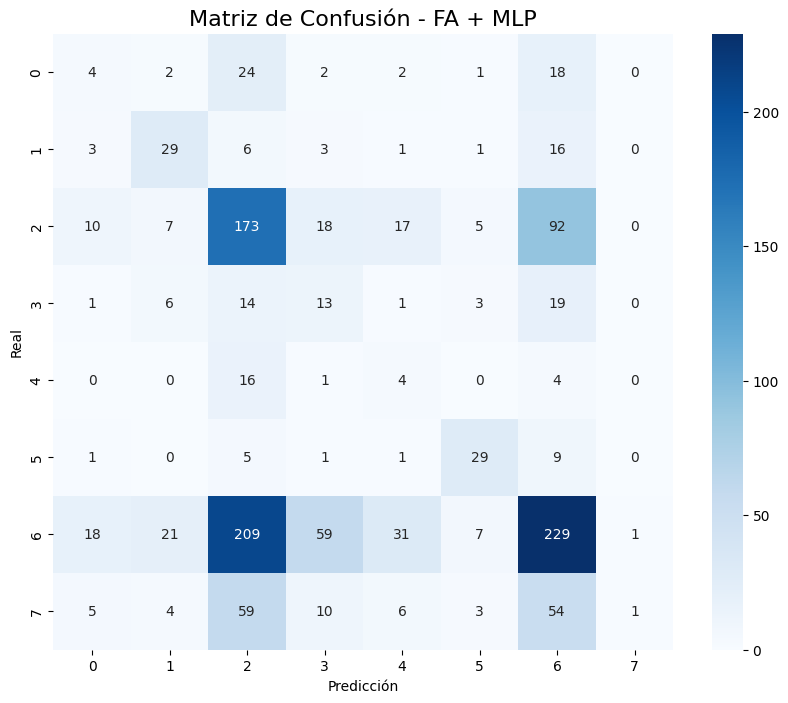

In [ ]:
modelo_af = entrenar_y_evaluar(X_train_af_sm, y_train_af_sm,
                               X_test_af, y_test,
                               "FA + MLP")


=== Entrenando modelo para: UMAP + MLP ===

Epoch 1/120
460/460 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.1919 - loss: 2.3061 - val_accuracy: 0.0000e+00 - val_loss: 3.2206 - learning_rate: 0.0010
Epoch 2/120
460/460 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2699 - loss: 1.9259 - val_accuracy: 0.0000e+00 - val_loss: 3.4676 - learning_rate: 0.0010
Epoch 3/120
460/460 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2703 - loss: 1.9036 - val_accuracy: 0.0000e+00 - val_loss: 3.4097 - learning_rate: 0.0010
Epoch 4/120
460/460 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2825 - loss: 1.8771 - val_accuracy: 0.0000e+00 - val_loss: 3.3500 - learning_rate: 0.0010
Epoch 5/120
460/460 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2882 - loss: 1.8756 - val_accuracy: 0.0000e+00 - val_loss: 3.4465 - learning_rate: 0.0010
Epoch 6/120
460/460 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2989 - loss: 1.8392 - val_accuracy: 0.0000e+00 - val_loss: 3.2939 - learning_rate: 0.0010
Epoch 7/120

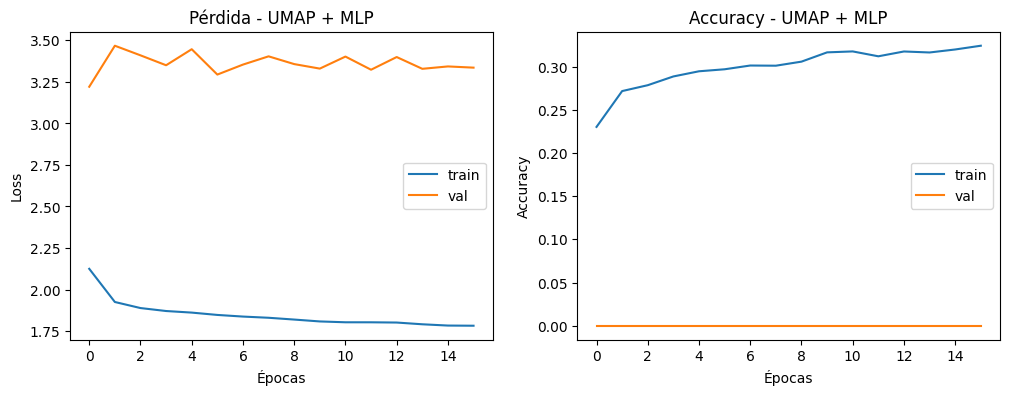

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
              precision    recall  f1-score   support

           0       0.02      0.06      0.03        53
           1       0.09      0.44      0.14        59
           2       0.37      0.09      0.14       322
           3       0.10      0.44      0.16        57
           4       0.03      0.32      0.05        25
           5       0.00      0.00      0.00        46
           6       0.44      0.17      0.25       575
           7       0.00      0.00      0.00       142

    accuracy                           0.15      1279
   macro avg       0.13      0.19      0.10      1279
weighted avg       0.30      0.15      0.16      1279



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


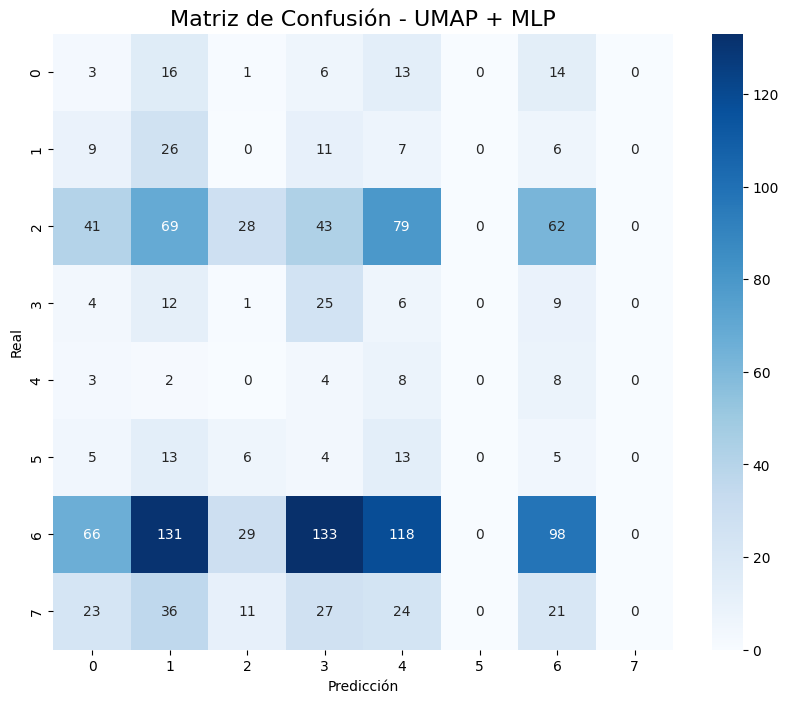

In [ ]:
modelo_umap = entrenar_y_evaluar(X_train_umap_sm, y_train_umap_sm,
                                 X_test_umap, y_test,
                                 "UMAP + MLP")

## Entrenamiento con class weight

In [ ]:
def entrenar_y_evaluar_class_weight(X_train, y_train, X_test, y_test, titulo):

    n_features = X_train.shape[1]
    n_classes = len(np.unique(y_train))

    modelo = crear_mlp_profundo(n_features, n_classes)

    # ---- class weights ----
    class_weights = calcular_class_weights(y_train)

    # Callbacks
    early_stop = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True
    )

    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=7,
        min_lr=1e-6
    )

    print(f"\n=== Entrenando modelo para: {titulo} ===\n")

    hist = modelo.fit(
        X_train,
        y_train,
        epochs=150,
        batch_size=64,              # batch mayor → entrenamiento más estable
        validation_split=0.2,
        class_weight=class_weights, # 🔥 CLAVE
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )

    # ---------- Evaluación ----------
    loss, acc = modelo.evaluate(X_test, y_test, verbose=0)
    print("\n================================")
    print(f" ACCURACY TEST ({titulo}):", acc)
    print(f" LOSS TEST ({titulo}):    ", loss)
    print("================================\n")


    # Curvas de entrenamiento
    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title(f"Pérdida - {titulo}")
    plt.xlabel("Épocas")
    plt.ylabel("Loss")
    plt.legend(["train", "val"])

    plt.subplot(1,2,2)
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title(f"Accuracy - {titulo}")
    plt.xlabel("Épocas")
    plt.ylabel("Accuracy")
    plt.legend(["train", "val"])

    plt.show()

   # ---------- Matriz de confusión ----------
    y_pred = modelo.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)

    print(classification_report(y_test, y_pred_labels))

    cm = confusion_matrix(y_test, y_pred_labels)

    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Matriz de Confusión - {titulo}", fontsize=16)
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()

    return modelo



=== Entrenando modelo para: PCA + MLP (class_weight) ===

Epoch 1/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 16s 99ms/step - accuracy: 0.1329 - loss: 2.7394 - val_accuracy: 0.1134 - val_loss: 2.9562 - learning_rate: 0.0010
Epoch 2/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1628 - loss: 2.2269 - val_accuracy: 0.1417 - val_loss: 2.4964 - learning_rate: 0.0010
Epoch 3/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1588 - loss: 2.0625 - val_accuracy: 0.1447 - val_loss: 2.2565 - learning_rate: 0.0010
Epoch 4/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1676 - loss: 2.0020 - val_accuracy: 0.1525 - val_loss: 2.1743 - learning_rate: 0.0010
Epoch 5/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1625 - loss: 1.9888 - val_accuracy: 0.1623 - val_loss: 2.1350 - learning_rate: 0.0010
Epoch 6/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1691 - loss: 1.9322 - val_accuracy: 0.1789 - val_loss: 2.0958 - learning_rate: 0.0010
Epoch 7/150
64/64 ━━━━━━━━━━━━━━━

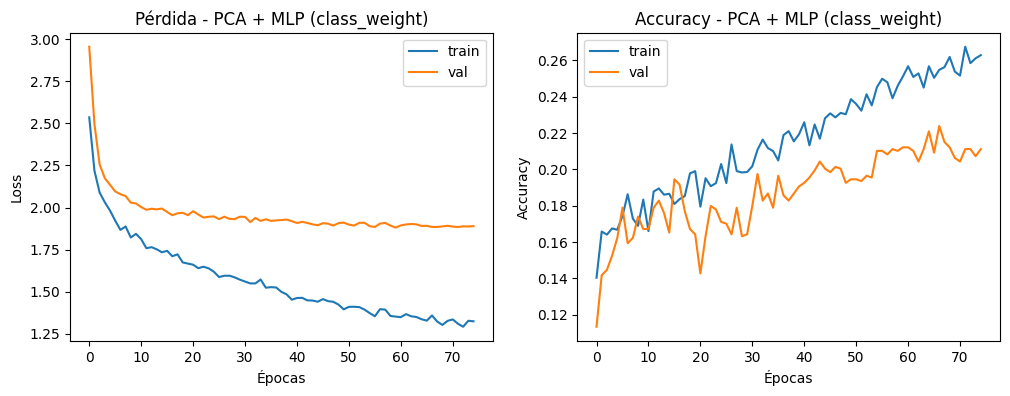

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
              precision    recall  f1-score   support

           0       0.06      0.26      0.10        53
           1       0.24      0.47      0.32        59
           2       0.34      0.22      0.27       322
           3       0.10      0.37      0.15        57
           4       0.05      0.40      0.09        25
           5       0.53      0.76      0.62        46
           6       0.53      0.07      0.12       575
           7       0.14      0.17      0.15       142

    accuracy                           0.19      1279
   macro avg       0.25      0.34      0.23      1279
weighted avg       0.38      0.19      0.19      1279



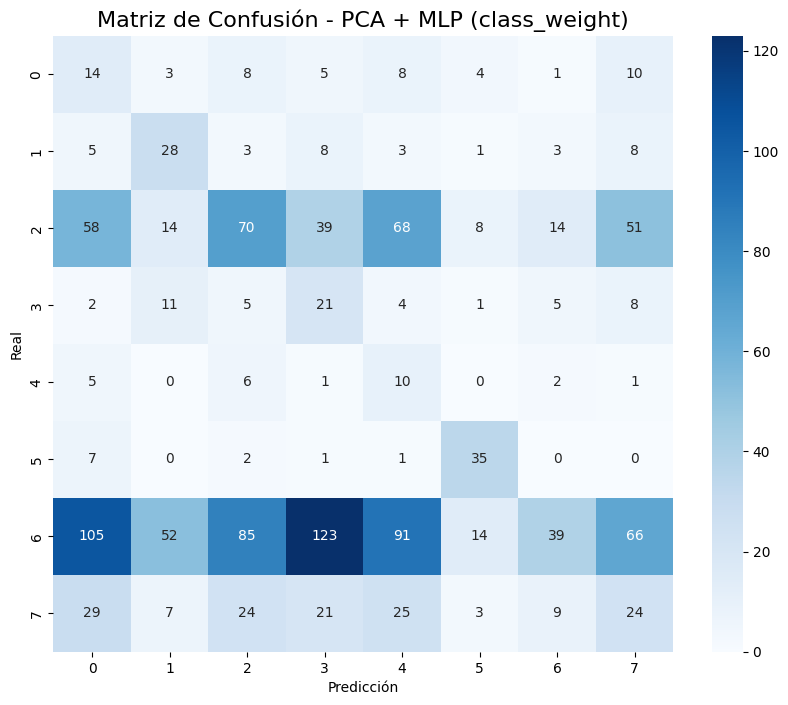

In [ ]:
modelo_pca = entrenar_y_evaluar_class_weight(
    X_train_pca, y_train,
    X_test_pca, y_test,
    "PCA + MLP (class_weight)"
)



=== Entrenando modelo para: FA + MLP (class_weight) ===

Epoch 1/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 90ms/step - accuracy: 0.1373 - loss: 2.6642 - val_accuracy: 0.1828 - val_loss: 2.2450 - learning_rate: 0.0010
Epoch 2/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1481 - loss: 2.1739 - val_accuracy: 0.1789 - val_loss: 2.1606 - learning_rate: 0.0010
Epoch 3/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1724 - loss: 2.0644 - val_accuracy: 0.1838 - val_loss: 2.1288 - learning_rate: 0.0010
Epoch 4/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1994 - loss: 1.9020 - val_accuracy: 0.1818 - val_loss: 2.1002 - learning_rate: 0.0010
Epoch 5/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1823 - loss: 1.9257 - val_accuracy: 0.1857 - val_loss: 2.0710 - learning_rate: 0.0010
Epoch 6/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1876 - loss: 1.8386 - val_accuracy: 0.1857 - val_loss: 2.0530 - learning_rate: 0.0010
Epoch 7/150
64/64 ━━━━━━━━━━━━━━━━

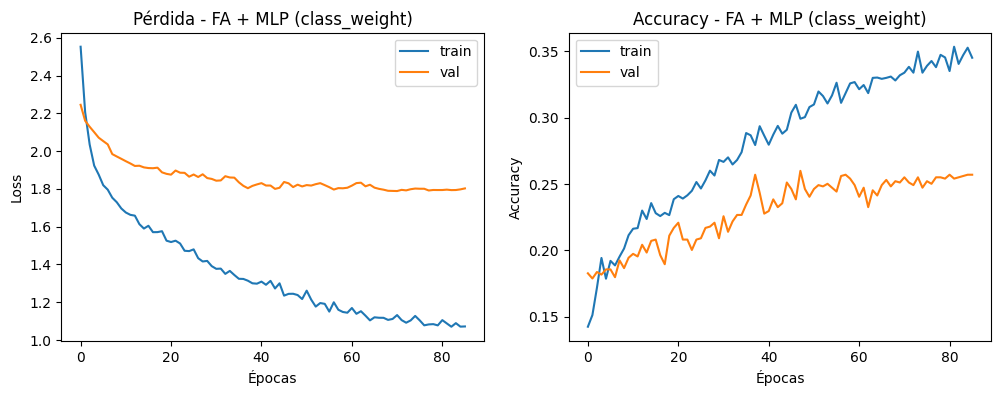

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
              precision    recall  f1-score   support

           0       0.05      0.17      0.08        53
           1       0.29      0.54      0.38        59
           2       0.33      0.33      0.33       322
           3       0.12      0.42      0.19        57
           4       0.06      0.28      0.11        25
           5       0.55      0.76      0.64        46
           6       0.53      0.11      0.18       575
           7       0.14      0.20      0.17       142

    accuracy                           0.24      1279
   macro avg       0.26      0.35      0.26      1279
weighted avg       0.38      0.24      0.24      1279



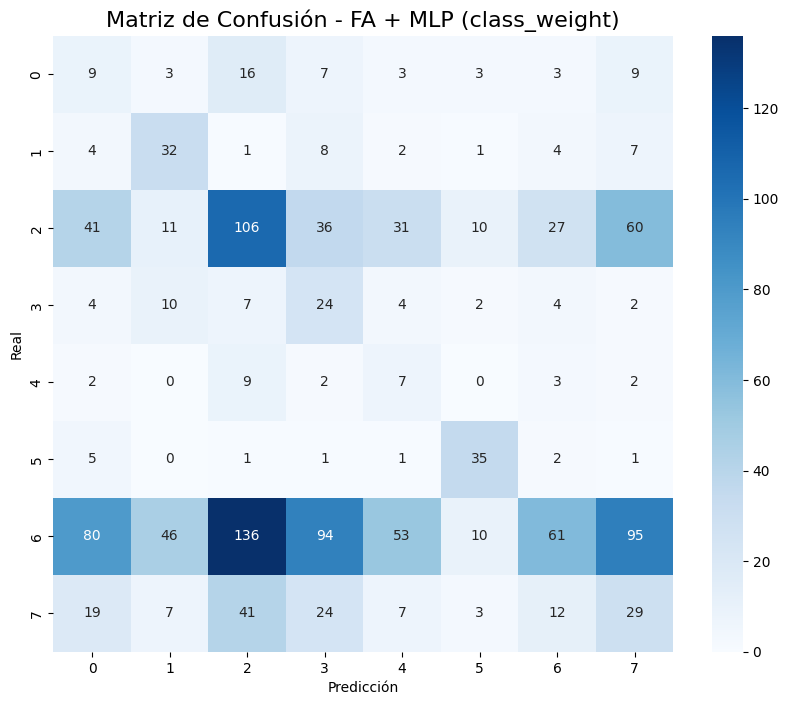

In [ ]:
modelo_af = entrenar_y_evaluar_class_weight(
    X_train_af, y_train,
    X_test_af, y_test,
    "FA + MLP (class_weight)"
)



=== Entrenando modelo para: UMAP + MLP (class_weight) ===

Epoch 1/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 98ms/step - accuracy: 0.1504 - loss: 2.5201 - val_accuracy: 0.0880 - val_loss: 2.2751 - learning_rate: 0.0010
Epoch 2/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1354 - loss: 2.2464 - val_accuracy: 0.0743 - val_loss: 2.1691 - learning_rate: 0.0010
Epoch 3/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1282 - loss: 2.1793 - val_accuracy: 0.1085 - val_loss: 2.1520 - learning_rate: 0.0010
Epoch 4/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1290 - loss: 2.1739 - val_accuracy: 0.1241 - val_loss: 2.1683 - learning_rate: 0.0010
Epoch 5/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1292 - loss: 2.0970 - val_accuracy: 0.1310 - val_loss: 2.1517 - learning_rate: 0.0010
Epoch 6/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1305 - loss: 2.1680 - val_accuracy: 0.1339 - val_loss: 2.1333 - learning_rate: 0.0010
Epoch 7/150
64/64 ━━━━━━━━━━━━━━

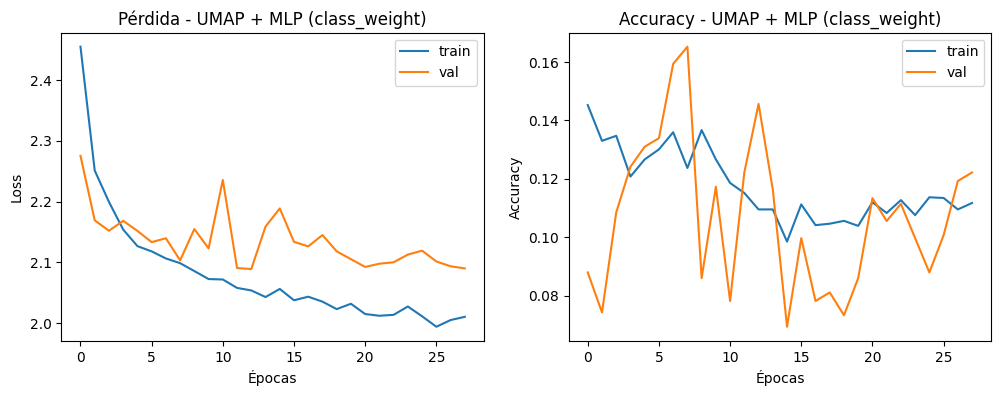

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
              precision    recall  f1-score   support

           0       0.06      0.19      0.09        53
           1       0.13      0.39      0.19        59
           2       0.41      0.15      0.22       322
           3       0.09      0.53      0.15        57
           4       0.03      0.16      0.06        25
           5       0.10      0.26      0.14        46
           6       0.47      0.07      0.12       575
           7       0.10      0.11      0.10       142

    accuracy                           0.14      1279
   macro avg       0.17      0.23      0.13      1279
weighted avg       0.34      0.14      0.15      1279



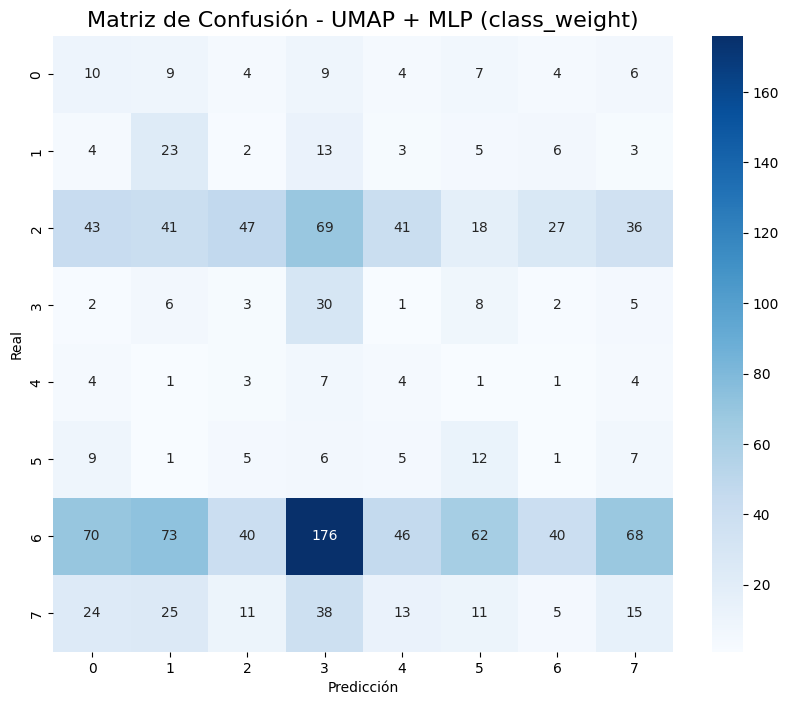

In [ ]:
modelo_umap = entrenar_y_evaluar_class_weight(
    X_train_umap, y_train,
    X_test_umap, y_test,
    "UMAP + MLP (class_weight)"
)


# Github

In [14]:
from google.colab import files
!cp "/content/drive/MyDrive/Colab Notebooks/Copia de EO.ipynb" "/content/"


In [15]:
import nbformat, os

ruta = "Copia de EO.ipynb"

if not os.path.exists(ruta):
    print(f"⚠️ No se encontró el archivo '{ruta}'. Verifica que esté en /content o descarga una copia desde Colab (Archivo → Descargar .ipynb).")
else:
    nb = nbformat.read(ruta, as_version=4)

    if "widgets" in nb.metadata:
        del nb.metadata["widgets"]
        nbformat.write(nb, ruta)
        print(f"✅ Se eliminaron los metadatos 'widgets' del archivo '{ruta}' correctamente.")
    else:
        print("ℹ️ El archivo no contenía metadatos 'widgets'. No se realizaron cambios.")


✅ Se eliminaron los metadatos 'widgets' del archivo 'Copia de EO.ipynb' correctamente.


In [12]:
files.download("Copia de EO.ipynb")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>